In [1]:
try: 
    import pykalman
except Exception:
    !pip install pystan
    !pip install pykalman
finally:
    import pykalman

# Naive Exploration

This initial section plots yield of crops against years and scales yield to a 0-1 range so that yield values can be compared

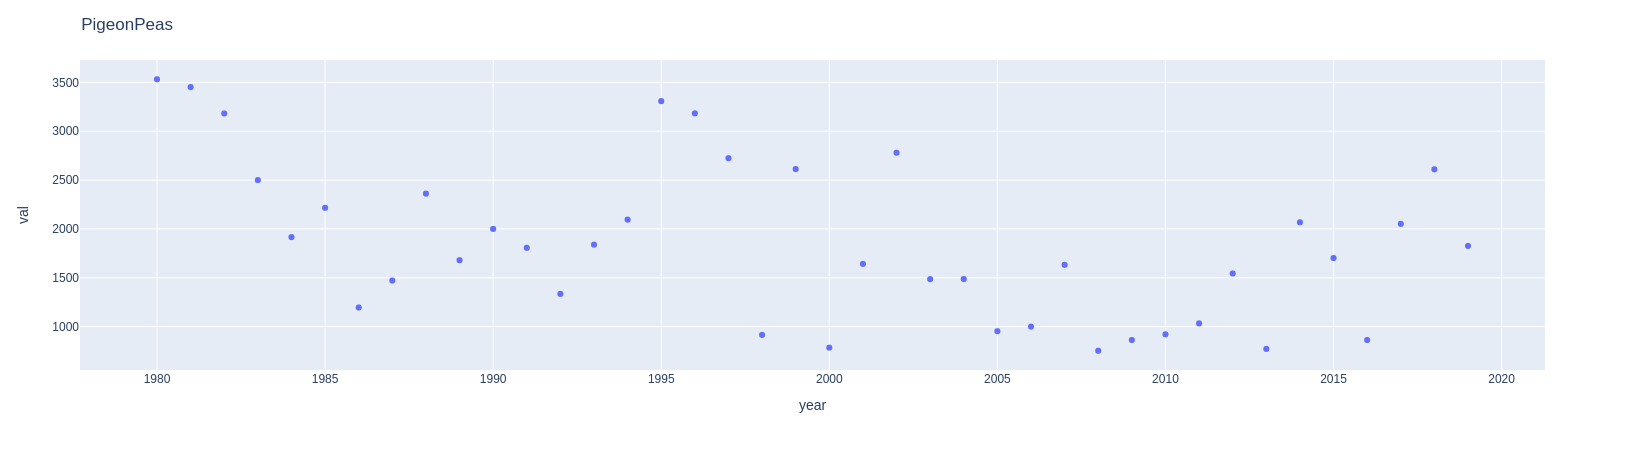

In [11]:
%matplotlib inline
import numpy as np
from plotly import express as px
import pandas as pd
from sklearn import preprocessing
from plotly import graph_objects as go
from plotly import express as px
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3 import *

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Area 220 is for Trinidad

df = dict()
# MinMax scaler used since historically, Trinidad's citrus output was overall higer 
scaler = preprocessing.MinMaxScaler()

def read_and_plot(csvname, areacode):
    temp_csv = pd.read_csv(csvname)
    temp_csv = temp_csv[temp_csv['Area Code'] == areacode]
    temp_csv.columns = ['area-code', 'year', 'val']
    # Trend removal by differencing
    temp_csv.val = temp_csv.val.diff()
    # Scaling
    temp_csv.val = scaler.fit_transform(np.array(temp_csv.val).reshape(-1, 1))
    # Removing data before 1980
    temp_csv = temp_csv[temp_csv.year >= 1980]
    fig=go.Figure()
    fig = px.scatter(temp_csv,x='year', y='val')
    plot_title = csvname.split('.')[0]
    fig.update_layout(
      title=f"{plot_title}")
    fig.show()
    return temp_csv

pigeon_peas = read_and_plot('PigeonPeas.csv', 220)

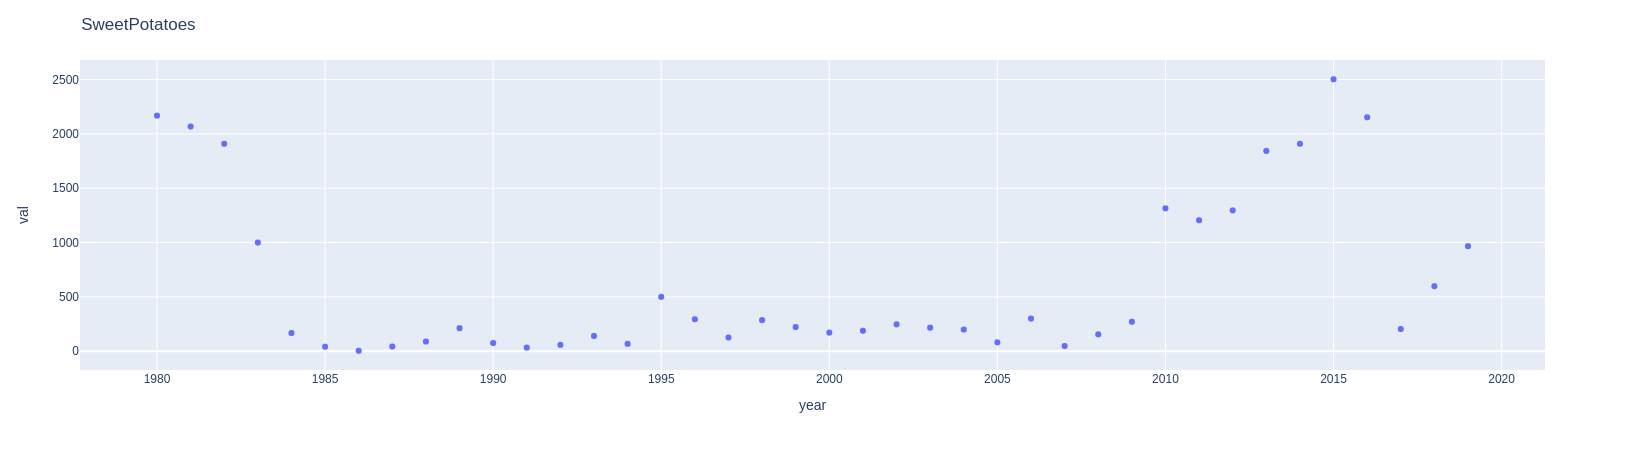

In [12]:
sweet_potato = read_and_plot('SweetPotatoes.csv', 220)

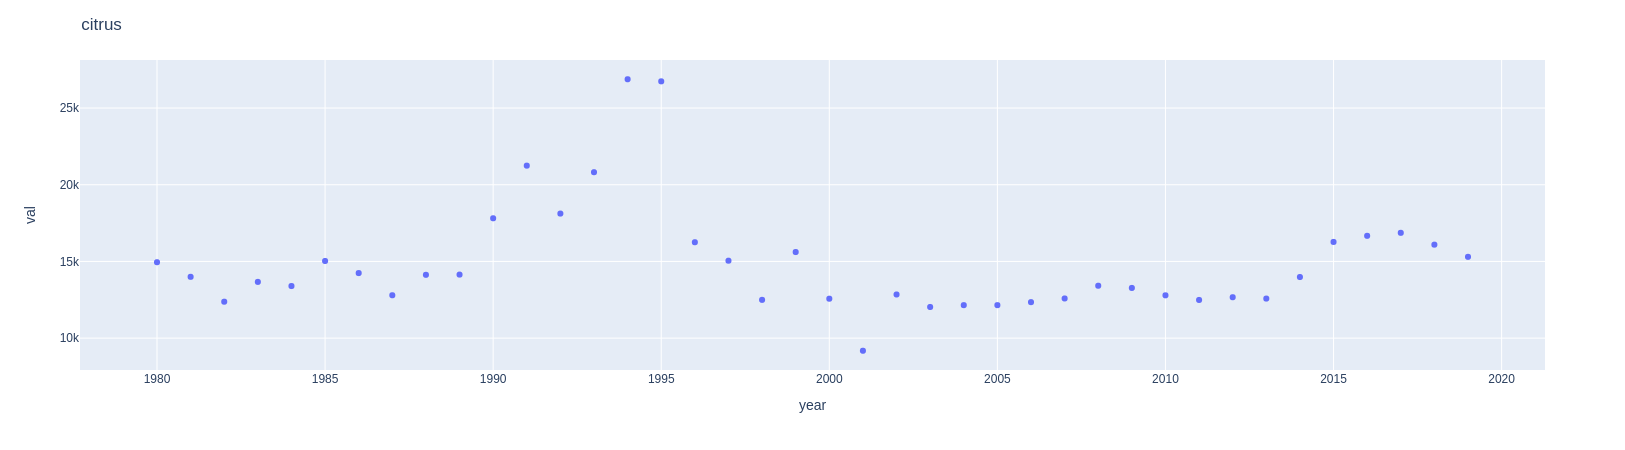

In [13]:
citrus = read_and_plot('citrus.csv', 220)

## Cleaning Weather Data

In [14]:
weather_df = pd.read_csv('weather-data.csv')
weather_df.head()

dt                         dt_iso  timezone            city_name  \
0  315532800  1980-01-01 00:00:00 +0000 UTC    -14400  Trinidad and Tobago   
1  315536400  1980-01-01 01:00:00 +0000 UTC    -14400  Trinidad and Tobago   
2  315540000  1980-01-01 02:00:00 +0000 UTC    -14400  Trinidad and Tobago   
3  315543600  1980-01-01 03:00:00 +0000 UTC    -14400  Trinidad and Tobago   
4  315547200  1980-01-01 04:00:00 +0000 UTC    -14400  Trinidad and Tobago   

         lat        lon    temp  feels_like  temp_min  temp_max  ...  \
0  10.691803 -61.222503  298.48      299.18   297.800   298.890  ...   
1  10.691803 -61.222503  298.46      299.38   297.798   298.903  ...   
2  10.691803 -61.222503  298.32      301.06   297.706   298.931  ...   
3  10.691803 -61.222503  298.28      301.00   297.660   298.933  ...   
4  10.691803 -61.222503  298.33      301.08   297.722   299.000  ...   

   wind_deg  rain_1h  rain_3h  snow_1h  snow_3h  clouds_all  weather_id  \
0        96     0.14      NaN      NaN      NaN          18         500   
1        95     0.14      NaN      NaN      NaN          24         500   
2        90      NaN      NaN      NaN      NaN          20         801   
3        90      NaN      NaN      NaN      NaN          20         801   
4        90      NaN      NaN      NaN      NaN          20         801   

   weather_main  weather_description  weather_icon  
0          Rain           light rain           10n  
1          Rain           light rain           10n  
2        Clouds           few clouds           02n  
3        Clouds           few clouds           02n  
4        Clouds           few clouds           02n  

[5 rows x 25 columns]

Dropping non-necessary columns

In [15]:
cols = [
  'dt', # Unix timestamp
  'timezone', # data is for Trinidad
  'city_name',
  'lat',
  'lon',
  'feels_like', # does not affect crops
  'sea_level', 
  'grnd_level',
  'snow_1h', # not applicable
  'snow_3h',
  'weather_id', # id for next column of general conditions
  'weather_icon', 
  'weather_description'
]

weather_df.drop(cols, axis=1, inplace=True)

Checking for null values, and exploring

In [16]:
weather_df.isna().sum()

dt_iso               0
temp                 0
temp_min             0
temp_max             0
pressure             0
humidity             0
wind_speed           0
wind_deg             0
rain_1h         315115
rain_3h         363199
clouds_all           0
weather_main         0
dtype: int64

In [17]:
weather_df[weather_df['rain_1h'].isna()].sample(15)

dt_iso    temp  temp_min  temp_max  pressure  \
145974  1996-05-09 02:00:00 +0000 UTC  299.50   299.150   300.150      1016   
99174   1991-01-11 10:00:00 +0000 UTC  297.28   296.350   298.225      1013   
41247   1984-06-23 10:00:00 +0000 UTC  298.27   297.932   298.570      1012   
142439  1995-12-14 07:00:00 +0000 UTC  296.53   295.150   298.386      1012   
110133  1992-04-11 03:00:00 +0000 UTC  298.61   298.325   298.721      1013   
87357   1989-09-06 09:00:00 +0000 UTC  298.58   297.659   298.857      1007   
189865  2001-04-30 06:00:00 +0000 UTC  298.57   297.738   299.450      1013   
231898  2006-02-05 00:00:00 +0000 UTC  297.65   297.150   298.403      1012   
54264   1985-12-02 15:00:00 +0000 UTC  298.81   297.913   299.747      1013   
124474  1993-11-28 07:00:00 +0000 UTC  297.09   296.150   298.150      1012   
18283   1981-12-06 21:00:00 +0000 UTC  299.22   299.021   299.584      1011   
152043  1997-01-15 01:00:00 +0000 UTC  297.85   296.875   298.748      1013   
145810  1996-05-02 11:00:00 +0000 UTC  300.41   298.410   302.150      1014   
358335  2020-06-16 05:00:00 +0000 UTC  298.54   297.590   299.520      1012   
260040  2009-04-16 11:00:00 +0000 UTC  299.11   298.940   299.150      1015   

        humidity  wind_speed  wind_deg  rain_1h  rain_3h  clouds_all  \
145974        83        3.60        70      NaN      NaN          75   
99174         81        3.10        60      NaN      NaN          72   
41247         83        6.29        73      NaN      NaN          20   
142439        94        5.23        71      NaN      NaN          20   
110133        85        3.60        70      NaN      NaN          75   
87357         94        2.10        80      NaN      NaN          40   
189865        89        2.10        70      NaN      NaN          20   
231898        74        2.60        90      NaN      NaN          75   
54264         90        6.20        60      NaN      NaN          40   
124474       100        5.61        70      NaN      NaN          20   
18283         88        5.10       230      NaN      NaN          75   
152043        81        1.50        70      NaN      NaN          40   
145810        79        4.10        70      NaN      NaN          20   
358335        88        7.04        71      NaN      NaN          40   
260040        78        3.10        70      NaN      NaN          75   

       weather_main  
145974       Clouds  
99174          Haze  
41247          Haze  
142439       Clouds  
110133         Haze  
87357        Clouds  
189865         Haze  
231898         Haze  
54264        Clouds  
124474       Clouds  
18283        Clouds  
152043       Clouds  
145810         Haze  
358335       Clouds  
260040       Clouds

In [18]:
weather_df[weather_df['rain_3h'].isna()].sample(15)

dt_iso    temp  temp_min  temp_max  pressure  \
222592  2005-01-15 18:00:00 +0000 UTC  299.08   297.950   301.150      1010   
1338    1980-02-22 09:00:00 +0000 UTC  294.46   293.150   296.823      1013   
181651  2000-05-24 07:00:00 +0000 UTC  297.79   297.150   298.514      1014   
109699  1992-03-24 01:00:00 +0000 UTC  298.00   296.934   298.950      1014   
200713  2002-07-23 16:00:00 +0000 UTC  303.44   300.612   305.150      1014   
334846  2017-10-14 17:00:00 +0000 UTC  299.47   297.150   304.150      1011   
298932  2013-09-13 16:00:00 +0000 UTC  302.37   300.602   303.600      1009   
23864   1982-07-09 09:00:00 +0000 UTC  296.76   296.383   297.295      1011   
12769   1981-05-17 13:00:00 +0000 UTC  300.42   299.079   301.150      1014   
81978   1989-01-26 01:00:00 +0000 UTC  297.18   296.950   297.548      1012   
322440  2016-05-17 20:00:00 +0000 UTC  303.26   300.722   304.150      1013   
103684  1991-07-17 21:00:00 +0000 UTC  300.77   299.513   301.650      1013   
153370  1997-03-11 01:00:00 +0000 UTC  297.57   296.690   298.150      1012   
267314  2010-02-12 01:00:00 +0000 UTC  298.29   298.150   298.567      1011   
227769  2005-08-18 04:00:00 +0000 UTC  299.11   298.150   300.422      1014   

        humidity  wind_speed  wind_deg  rain_1h  rain_3h  clouds_all  \
222592        95        1.50       100      0.5      NaN          90   
1338          93        5.68        70      NaN      NaN           1   
181651       100        6.51       102      NaN      NaN          20   
109699        77        2.60        80      NaN      NaN           1   
200713        62        6.70        70      NaN      NaN          20   
334846        94        3.10       120      1.5      NaN          75   
298932        70        1.54       250      NaN      NaN          75   
23864         96        1.50        80      0.3      NaN          40   
12769         83        4.60        70      NaN      NaN          20   
81978         85        2.60        70      NaN      NaN          23   
322440        66        9.26       110      0.3      NaN          40   
103684        73        4.60        80      NaN      NaN          40   
153370        80        2.10        70      NaN      NaN          20   
267314        83        6.56        80      NaN      NaN          20   
227769        94        5.34       103      NaN      NaN          20   

        weather_main  
222592          Rain  
1338           Clear  
181651        Clouds  
109699         Clear  
200713        Clouds  
334846  Thunderstorm  
298932        Clouds  
23864           Rain  
12769         Clouds  
81978           Haze  
322440          Rain  
103684        Clouds  
153370          Dust  
267314        Clouds  
227769        Clouds

The remaining weather columns are differenced using n=1, in order to stabilise the mean and reduced any sharp changes in level. This step is done since the response of crops to weather may not correlate directly. The side-effect of this results in the future model steps assigning unnecessarily high weights to weather features with these fluctuations, resulting in uncontrolled variance of the predictions 

In [35]:
cols_to_difference = [
    'temp',
    'temp_min',
    'temp_max',
    'pressure',
    'humidity',
    'wind_speed',
    'wind_deg',
    'rain_1h',
    'rain_3h',
    'clouds_all',
]

weather_df[cols_to_difference] = weather_df[cols_to_difference].diff()
weather_df.head()

dt_iso  temp  temp_min  temp_max  pressure  \
0  1980-01-01 00:00:00 +0000 UTC   NaN       NaN       NaN       NaN   
1  1980-01-01 01:00:00 +0000 UTC -0.02    -0.002     0.013       0.0   
2  1980-01-01 02:00:00 +0000 UTC -0.14    -0.092     0.028       1.0   
3  1980-01-01 03:00:00 +0000 UTC -0.04    -0.046     0.002       0.0   
4  1980-01-01 04:00:00 +0000 UTC  0.05     0.062     0.067       0.0   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  clouds_all weather_main  
0       NaN         NaN       NaN      NaN      NaN         NaN         Rain  
1       1.0       -0.18      -1.0      0.0      NaN         6.0         Rain  
2      -1.0       -2.87      -5.0      NaN      NaN        -4.0       Clouds  
3       0.0        0.00       0.0      NaN      NaN         0.0       Clouds  
4       0.0        0.00       0.0      NaN      NaN         0.0       Clouds

## Data Averaging

Data will be averaged across weeks (since crop yield data is not at such a level of granularity). Hence NaN values will be averaged out (as recommended by climated.gov)

In [19]:
year_range = range(1981, 2020, 1)


year_vals = dict()
month_vals = dict()
month_weather_df = pd.DataFrame(columns=['year', 'month', 'temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean', 'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var'])

for year in year_range:
    year_df = weather_df.copy()
    year_df = year_df[year_df['dt_iso'] < f'{year+1}-01-01 00:00:00 +0000 UTC']
    year_df = year_df[year_df['dt_iso'] >= f'{year}-01-01 00:00:00 +0000 UTC' ]
    for month in range(1,13, 1):
        month_df = year_df.copy()
        month_df = month_df[month_df['dt_iso'] < f'{year+1}-0{month+1}-01 00:00:00 +0000 UTC']
        month_df = month_df[month_df['dt_iso'] >= f'{year}-0{month}-01 00:00:00 +0000 UTC' ]
        month_vals = dict({
          'year': int(year),
          'month': int(month),
          'temp_max' : month_df.temp_max.mean(),
          'temp_min' : month_df.temp_min.mean(),
          'temp' : month_df.temp.mean(),
          'pressure_var': month_df.pressure.var(),
          'pressure_mean': month_df.pressure.mean(),
          'humidity_mean': month_df.humidity.mean(),
          'humidity_var': month_df.humidity.var(),
          'rain_mean': month_df.rain_1h.mean(),
          'rain_var': month_df.rain_1h.var()
        })
        
        month_weather_df = month_weather_df.append(month_vals, ignore_index=True)


month_weather_df.year = month_weather_df.year.astype(int)
month_weather_df.month = month_weather_df.month.astype(int)
month_weather_df.set_index(['month', 'year'], inplace=True)

month_weather_df.head()
month_weather_df.to_json('month_weather.json')

In [37]:
year_range = range(1980, 2020, 1)


year_vals = dict()
year_weather_df = pd.DataFrame(columns=['year', 'temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean', 'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var'])

for year in year_range:
    year_df = weather_df.copy()
    year_df = year_df[year_df['dt_iso'] < f'{year+1}-01-01 00:00:00 +0000 UTC']
    year_df = year_df[year_df['dt_iso'] >= f'{year}-01-01 00:00:00 +0000 UTC' ]
    year_vals[year] = dict({
      'year': int(year),
      'temp_max' : year_df.temp_max.mean(),
      'temp_min' : year_df.temp_min.mean(),
      'temp' : year_df.temp.mean(),
      'pressure_var': year_df.pressure.var(),
      'pressure_mean': year_df.pressure.mean(),
      'humidity_mean': year_df.humidity.mean(),
      'humidity_var': year_df.humidity.var(),
      'rain_mean': year_df.rain_1h.mean(),
      'rain_var': year_df.rain_1h.var()
    })

    year_weather_df = year_weather_df.append(year_vals[year], ignore_index=True)

year_weather_df.year = year_weather_df.year.astype(int)

In [38]:
year_weather_df.head()

year  temp_min  temp_max      temp  pressure_var  pressure_mean  \
0  1980 -0.000070  0.000028 -0.000015     10.772157       0.000000   
1  1981  0.000115 -0.000050  0.000015      0.435052      -0.000206   
2  1982 -0.000143  0.000052 -0.000016      0.474863       0.000108   
3  1983 -0.000055 -0.000129 -0.000111      0.468318       0.000228   
4  1984  0.000032 -0.000016  0.000003      0.478130       0.000000   

   humidity_mean  humidity_var  rain_mean  rain_var  
0      -0.000540     45.783938   0.030155  0.269324  
1       0.000412     43.019381  -0.012264  0.575347  
2      -0.000431     40.905587   0.016544  0.446519  
3       0.000114      3.184953   0.014739  0.294580  
4      -0.000556     53.355481   0.010892  0.360374

Weather features are scaled within the range 0-1 and the scalers are saved for future work. Scaliing assists in normalising the uncontrolled effect of certain weather parameters being and order of magnitude larger/smaller than others. For example, pressure is usually of order $10^2$ whilst wind speed is of order $10^{0}$

In [39]:
from pickle import dump
from sklearn.preprocessing import MinMaxScaler

weather_scaler = MinMaxScaler()

cols_to_scale = ['temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean', 'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var']
# weather_scaler.fit(year_weather_df[cols_to_scale])

# year_weather_df[cols_to_scale] = weather_scaler.transform(year_weather_df[cols_to_scale])

temp_min_scaler = MinMaxScaler()
year_weather_df['temp_min'] = temp_min_scaler.fit_transform(np.array(year_weather_df['temp_min']).reshape(-1, 1))
dump(temp_min_scaler, open('temp_min_scaler.pkl', 'wb'))

temp_max_scaler = MinMaxScaler()
year_weather_df['temp_max'] = temp_max_scaler.fit_transform(np.array(year_weather_df['temp_max']).reshape(-1, 1))
dump(temp_max_scaler, open('temp_max_scaler.pkl', 'wb'))

temp_scaler = MinMaxScaler()
year_weather_df['temp'] = temp_scaler.fit_transform(np.array(year_weather_df['temp']).reshape(-1, 1))
dump(temp_scaler, open('temp_scaler.pkl', 'wb'))

pressure_var_scaler = MinMaxScaler()
year_weather_df['pressure_var'] = pressure_var_scaler.fit_transform(np.array(year_weather_df['pressure_var']).reshape(-1, 1))
dump(pressure_var_scaler, open('pressure_var_scaler.pkl', 'wb'))

pressure_mean_scaler = MinMaxScaler()
year_weather_df['pressure_mean'] = pressure_mean_scaler.fit_transform(np.array(year_weather_df['pressure_mean']).reshape(-1, 1))
dump(pressure_mean_scaler, open('pressure_mean_scaler.pkl', 'wb'))


humidity_mean_scaler = MinMaxScaler()
year_weather_df['humidity_mean'] = humidity_mean_scaler.fit_transform(np.array(year_weather_df['humidity_mean']).reshape(-1, 1))
dump(humidity_mean_scaler, open('humidity_mean_scaler.pkl', 'wb'))

humidity_var_scaler = MinMaxScaler()
year_weather_df['humidity_var'] = humidity_var_scaler.fit_transform(np.array(year_weather_df['humidity_var']).reshape(-1, 1))
dump(humidity_var_scaler, open('humidity_var_scaler.pkl', 'wb'))

rain_mean_scaler = MinMaxScaler()
year_weather_df['rain_mean'] = rain_mean_scaler.fit_transform(np.array(year_weather_df['rain_mean']).reshape(-1, 1))
dump(rain_mean_scaler, open('rain_mean_scaler.pkl', 'wb'))

rain_var_scaler = MinMaxScaler()
year_weather_df['rain_var'] = rain_var_scaler.fit_transform(np.array(year_weather_df['rain_var']).reshape(-1, 1))
dump(rain_var_scaler, open('rain_var_scaler.pkl', 'wb'))


# dump(weather_scaler, open('weather_scaler.pkl', 'wb'))

*Utility function to plot a named weather feature against time*

In [40]:
def plot_weather(weather):
    fig = go.Figure()
    for param in weather:
        fig.add_trace(
            go.Scatter(x=year_weather_df.year, y=year_weather_df[param], name=str(param))
        )
        fig.update_layout(
          xaxis_title='Year',
          title=f'Weather Parameters: {[w for w in weather]}'
        )
    fig.show()

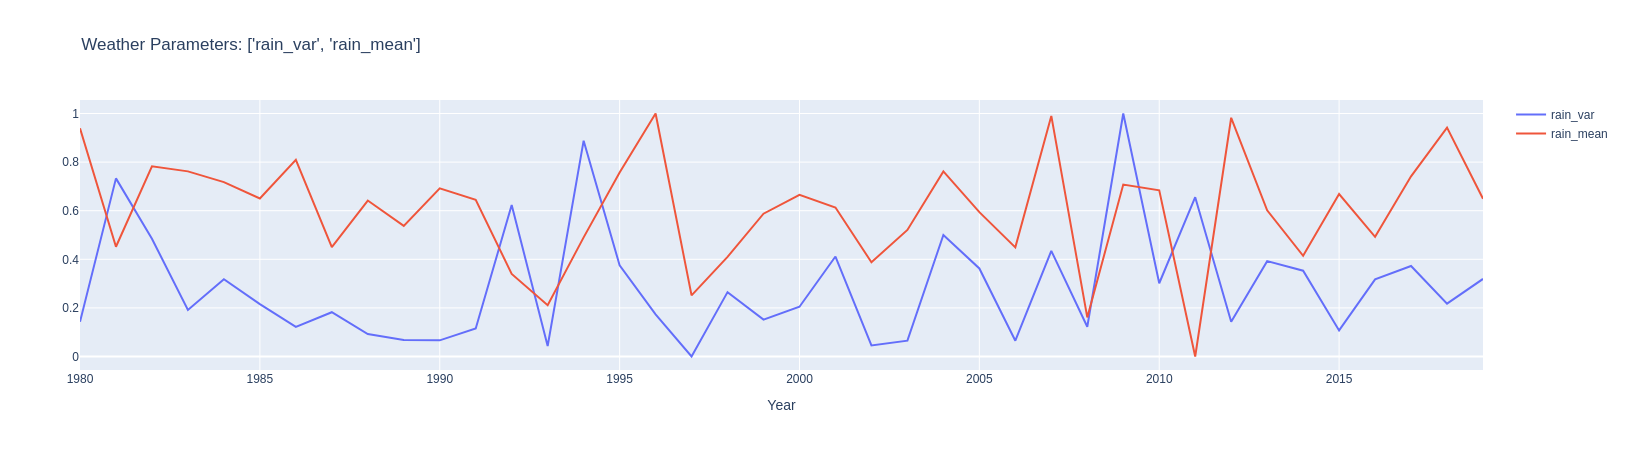

In [41]:
plot_weather(['rain_var', 'rain_mean'])

In [42]:
plot_weather(['pressure_var', 'pressure_mean'])

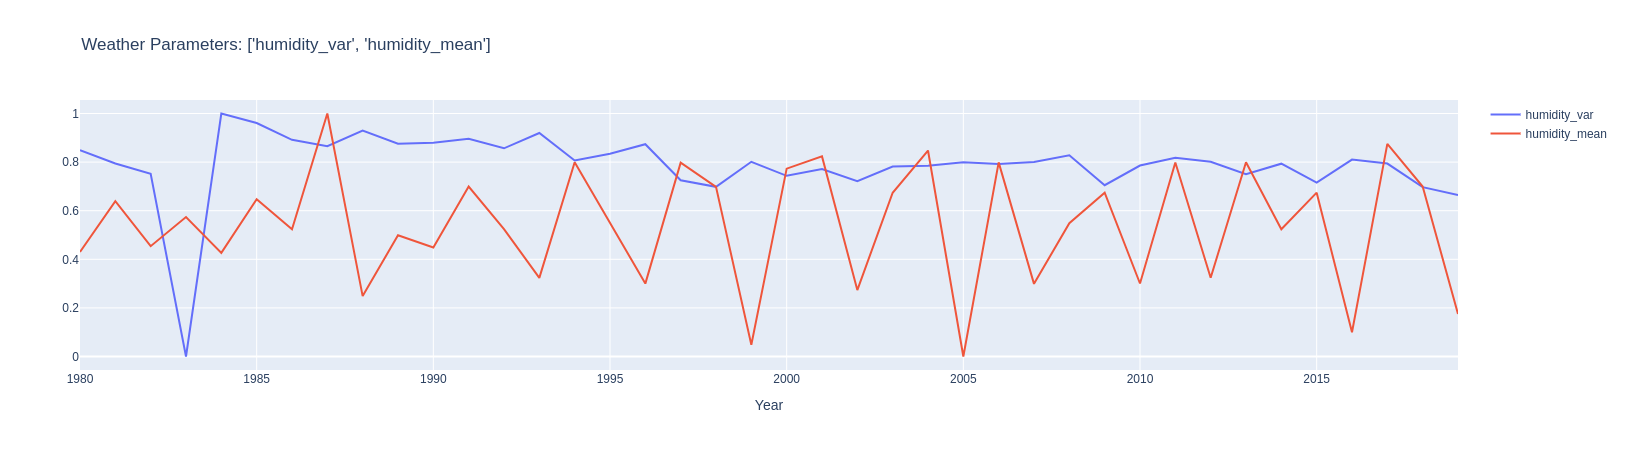

In [43]:
plot_weather(['humidity_var', 'humidity_mean'])

*Utility functiont to plot crop yield against a named weather feature*

In [44]:
def plot_against(p1, p2, title='', p1_name='', p2_name=''):
    fig = px.scatter(x=p1, y=p2, title=title, trendline='ols')
    fig.update_layout(
      xaxis_title=p1_name,
      yaxis_title=p2_name
    )
    return fig

In [45]:
year_weather_df.columns

Index(['year', 'temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean',
       'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var'],
      dtype='object')

## Plotting Yield Against Weather

The crop yield for all crops are plotted against all weather features to get a general idea of correlation

In [46]:
from plotly.subplots import make_subplots
def plot_against_all(crop, title=''):
    fig = make_subplots(rows=3, cols=3,
                      subplot_titles=("Min Temp","Mean Pressure", "Variance in Pressure", 'Max Temp', 'Mean Humidity', 'Variance in Humidity', 'Temp', 'Mean Rain', 'Variance in Rain'))
    # Temperatures
    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.temp_min), y=np.asarray(crop.val), mode='markers', name='Min Temp'), col=1, row=1
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.temp_max), y=np.asarray(crop.val), mode='markers'), col=1, row=2
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.temp), y=np.asarray(crop.val), mode='markers'), col=1, row=3
    )

    # Pressure
    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.pressure_mean), y=np.asarray(crop.val), mode='markers'), col=2, row=1
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.pressure_var), y=np.asarray(crop.val), mode='markers'), col=3, row=1
    )

    # Humidity
    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.humidity_mean), y=np.asarray(crop.val), mode='markers'), col=2, row=2
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.humidity_var), y=np.asarray(crop.val), mode='markers'), col=2, row=3
    )

    # Rain
    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.rain_mean), y=np.asarray(crop.val), mode='markers'), col=3, row=2
    )

    fig.add_trace(
      go.Scatter(x=np.asarray(year_weather_df.rain_var), y=np.asarray(crop.val), mode='markers'), col=3, row=3
    )
    fig.update_layout(
      showlegend=False, 
      title=f'Crop Yield for {title} against Weather',
      autosize=False,
      width=1200,
      height=1200
    )

    fig.update_xaxes(type='log')
    return fig


In [47]:
plot_against_all(pigeon_peas, title='Pigeon Peas')

In [48]:
plot_against_all(citrus, title='Citrus')

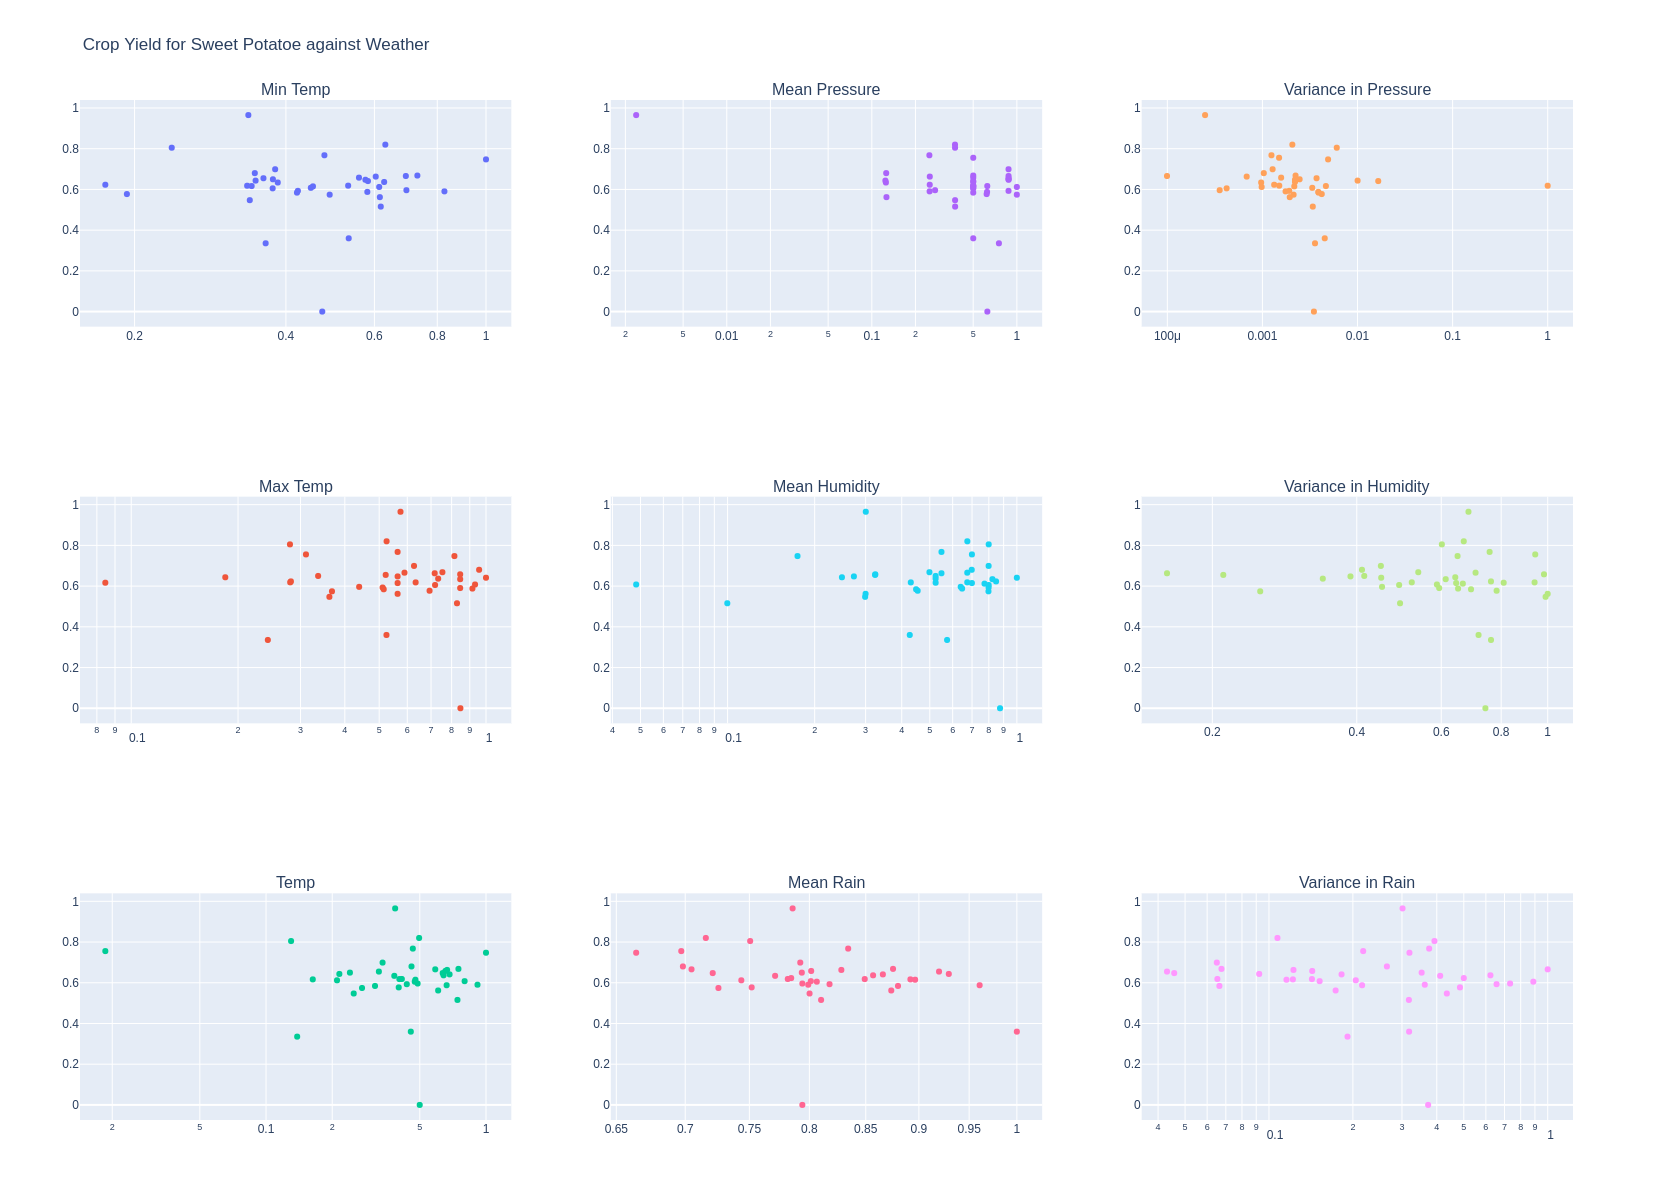

In [49]:
plot_against_all(sweet_potato, title='Sweet Potatoe')

# Exploration for Correlation using Spearman and Pearson

Since the above plots do not make correlation obvious, test-statistics will be used to investigate the level of correlation between yield for each crop against all weather parameters. The weather-parameters with a significant level of correlation per crop will be retained to build the model

The following finds the pearsonr and spearman correlation coefficients for all the crops against the weather variables, instead of attempting to fit a model against all weather features, we first look for weather features that already show statistical correlation and build transformations around these features

## Pigeon Peas

From the result below, **temp_min (exp), temp_min(None), and temp_max(log)** would be explored owing to their p-values

In [53]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

pigeon_peas_formula = 'val ~ np.exp(temp_min) + temp_min + temp_max'

weather_features = [str(f) for f in year_weather_df.columns[1:]]

def calculate_correlation(crop_df):
    vals = pd.DataFrame(columns=['transform', 'feature', 'pearsonr', 'p1', 'spearmanr', 'p2', 'cov'])
    TRANSFORM = None
    crop_val = crop_df.val.values
    for f in weather_features:
        weather_feature = year_weather_df[f].values
        spearman = spearmanr(np.array(weather_feature), crop_df.val.values)
        pearson = pearsonr(np.array(weather_feature), crop_df.val.values)
        covariance = np.cov(np.hstack([weather_feature, crop_df.val.values]))
        vals = vals.append({'transform': TRANSFORM, 'feature':f, 'pearsonr': pearson[0], 'p1': pearson[1], 'spearmanr': spearman[0], 'p2': spearman[1], 'cov':covariance}, ignore_index=True)
    
    TRANSFORM = 'log'
#     for f in weather_features:
#         print(f)
#         weather_feature = np.log(year_weather_df[f].values)
#         spearman = spearmanr(weather_feature, crop_df.val.values)
#         pearson = pearsonr(weather_feature, crop_df.val.values)[0]
#         covariance = np.cov(np.hstack([weather_feature, crop_df.val.values]))
#         vals = vals.append({'transform': TRANSFORM, 'feature':f, 'pearsonr': pearson, 'spearmanr': spearman[0], 'p': spearman[1], 'cov': covariance}, ignore_index=True)
    
    TRANSFORM = 'exp'
    for f in weather_features:
        weather_feature = np.exp(year_weather_df[f].values, dtype=np.float128)
        spearman = spearmanr(weather_feature, crop_df.val.values)
        pearson = pearsonr(weather_feature, crop_df.val.values)
        vals = vals.append({'transform': TRANSFORM, 'feature':f, 'pearsonr': pearson[0], 'p1': pearson[1], 'spearmanr': spearman[0], 'p2': spearman[1], 'cov': covariance}, ignore_index=True)
 
    return vals.sort_values(['p1', 'p2'])


calculate_correlation(pigeon_peas)

transform        feature  pearsonr        p1  spearmanr        p2  \
9        exp       temp_min -0.251880  0.116901  -0.244653  0.128139   
0       None       temp_min -0.236348  0.142025  -0.244653  0.128139   
1       None       temp_max  0.186259  0.249834   0.138345  0.394585   
6       None   humidity_var  0.174431  0.281707   0.160600  0.322192   
15       exp   humidity_var  0.173729  0.283676   0.160600  0.322192   
10       exp       temp_max  0.151980  0.349182   0.138345  0.394585   
5       None  humidity_mean -0.128702  0.428671  -0.048126  0.768074   
16       exp      rain_mean  0.125994  0.438526   0.098874  0.543853   
7       None      rain_mean  0.112726  0.488596   0.098874  0.543853   
14       exp  humidity_mean -0.107401  0.509487  -0.048126  0.768074   
17       exp       rain_var  0.074332  0.648504   0.080863  0.619881   
8       None       rain_var  0.074270  0.648776   0.080863  0.619881   
4       None  pressure_mean  0.066441  0.683761   0.097470  0.549616   
13       exp  pressure_mean  0.047620  0.770447   0.097470  0.549616   
11       exp           temp -0.020964  0.897833  -0.038274  0.814616   
12       exp   pressure_var -0.003755  0.981654  -0.042402  0.795031   
3       None   pressure_var -0.003094  0.984885  -0.042402  0.795031   
2       None           temp -0.002071  0.989881  -0.038274  0.814616   

                    cov  
9   0.06526484708137437  
0   0.04391437824063992  
1   0.05860573476949709  
6   0.05769483280779591  
15  0.06526484708137437  
10  0.06526484708137437  
5   0.05678841820539136  
16  0.06526484708137437  
7   0.05468875744552527  
14  0.06526484708137437  
17  0.06526484708137437  
8   0.06526484708137437  
4   0.06324376160146988  
13  0.06526484708137437  
11  0.06526484708137437  
12  0.06526484708137437  
3   0.09667431055752343  
2   0.05355149545232404

## Citrus

From the results below **rain_mean (exp), pressure_mean(None) and rain_var(exp)** will be explored owing to their p-values

In [54]:
citrus_formula = 'val ~ np.exp(rain_mean) + pressure_mean + np.exp(rain_var)'
calculate_correlation(citrus)

transform        feature  pearsonr        p1  spearmanr        p2  \
16       exp      rain_mean -0.259478  0.105905  -0.094184  0.563217   
4       None  pressure_mean  0.250307  0.119282   0.188664  0.243660   
7       None      rain_mean -0.219452  0.173647  -0.094184  0.563217   
13       exp  pressure_mean  0.202514  0.210122   0.188664  0.243660   
9        exp       temp_min -0.133559  0.411302  -0.091932  0.572624   
0       None       temp_min -0.120886  0.457461  -0.091932  0.572624   
5       None  humidity_mean -0.065362  0.688639  -0.202261  0.210704   
14       exp  humidity_mean -0.064335  0.693287  -0.202261  0.210704   
8       None       rain_var -0.032139  0.843930  -0.278612  0.081705   
1       None       temp_max  0.026828  0.869474  -0.013046  0.936318   
6       None   humidity_var -0.022192  0.891885   0.230019  0.153331   
11       exp           temp -0.015246  0.925609   0.058537  0.719755   
2       None           temp -0.014607  0.928717   0.058537  0.719755   
17       exp       rain_var  0.014192  0.930736  -0.278612  0.081705   
12       exp   pressure_var -0.011907  0.941871   0.122702  0.450680   
3       None   pressure_var -0.011765  0.942563   0.122702  0.450680   
10       exp       temp_max  0.006063  0.970383  -0.013046  0.936318   
15       exp   humidity_var  0.000491  0.997600   0.230019  0.153331   

                     cov  
16   0.03739526246546382  
4     0.0404921766179392  
7   0.034676213242960455  
13   0.03739526246546382  
9    0.03739526246546382  
0    0.02072604696598088  
5      0.035179619922625  
14   0.03739526246546382  
8    0.03739526246546382  
1   0.037800255531344036  
6   0.042338947415077675  
11   0.03739526246546382  
2   0.029800380212532743  
17   0.03739526246546382  
12   0.03739526246546382  
3    0.06218919848615583  
10   0.03739526246546382  
15   0.03739526246546382

## Sweet Potato

From the results below, **pressure_mean (exp), pressure_mean (None) and humidity_var (None) ** will be explored owing to their p-values

In [55]:
potato_formula = 'val ~ np.exp(pressure_mean) + pressure_mean + humidity_var'
calculate_correlation(sweet_potato)

transform        feature  pearsonr        p1  spearmanr        p2  \
4       None  pressure_mean -0.274919  0.086005  -0.263122  0.100920   
13       exp  pressure_mean -0.229671  0.153971  -0.263122  0.100920   
6       None   humidity_var  0.134193  0.409064  -0.258912  0.106697   
14       exp  humidity_mean -0.106678  0.512358   0.096721  0.552702   
16       exp      rain_mean -0.096452  0.553812  -0.166229  0.305297   
7       None      rain_mean -0.091935  0.572612  -0.166229  0.305297   
5       None  humidity_mean -0.089328  0.583592   0.096721  0.552702   
10       exp       temp_max -0.086568  0.595321   0.031067  0.849075   
1       None       temp_max -0.071246  0.662207   0.031067  0.849075   
15       exp   humidity_var  0.060506  0.710729  -0.258912  0.106697   
8       None       rain_var -0.058779  0.718643  -0.129268  0.426623   
0       None       temp_min -0.041627  0.798695  -0.047842  0.769404   
17       exp       rain_var -0.041047  0.801446  -0.129268  0.426623   
11       exp           temp  0.012253  0.940184  -0.006754  0.967006   
2       None           temp -0.007317  0.964258  -0.006754  0.967006   
3       None   pressure_var -0.002090  0.989789  -0.180675  0.264564   
9        exp       temp_min -0.002037  0.990045  -0.047842  0.769404   
12       exp   pressure_var -0.001390  0.993206  -0.180675  0.264564   

                     cov  
4   0.051107699410462566  
13   0.06475402009755156  
6   0.028759873891410354  
14   0.06475402009755156  
16   0.06475402009755156  
7     0.0363311251865279  
5    0.04205658322378502  
10   0.06475402009755156  
1    0.04204920781625454  
15   0.06475402009755156  
8    0.06475402009755156  
0    0.03277035956759427  
17   0.06475402009755156  
11   0.06475402009755156  
2   0.043685807462247185  
3    0.11119026517069605  
9    0.06475402009755156  
12   0.06475402009755156

# GLM Modeling
## Sweet Potato

In [34]:
year_weather_df.columns

Index(['year', 'temp_min', 'temp_max', 'temp', 'pressure_var', 'pressure_mean',
       'humidity_mean', 'humidity_var', 'rain_mean', 'rain_var'],
      dtype='object')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 26700
Interrupted at 26,699 [13%]: Average Loss = 148.99
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, humidity_var, pressure_mean, np.exp(pressure_mean), Intercept]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 182 seconds.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1661 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.880985504520557, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3460 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6182985108138997, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


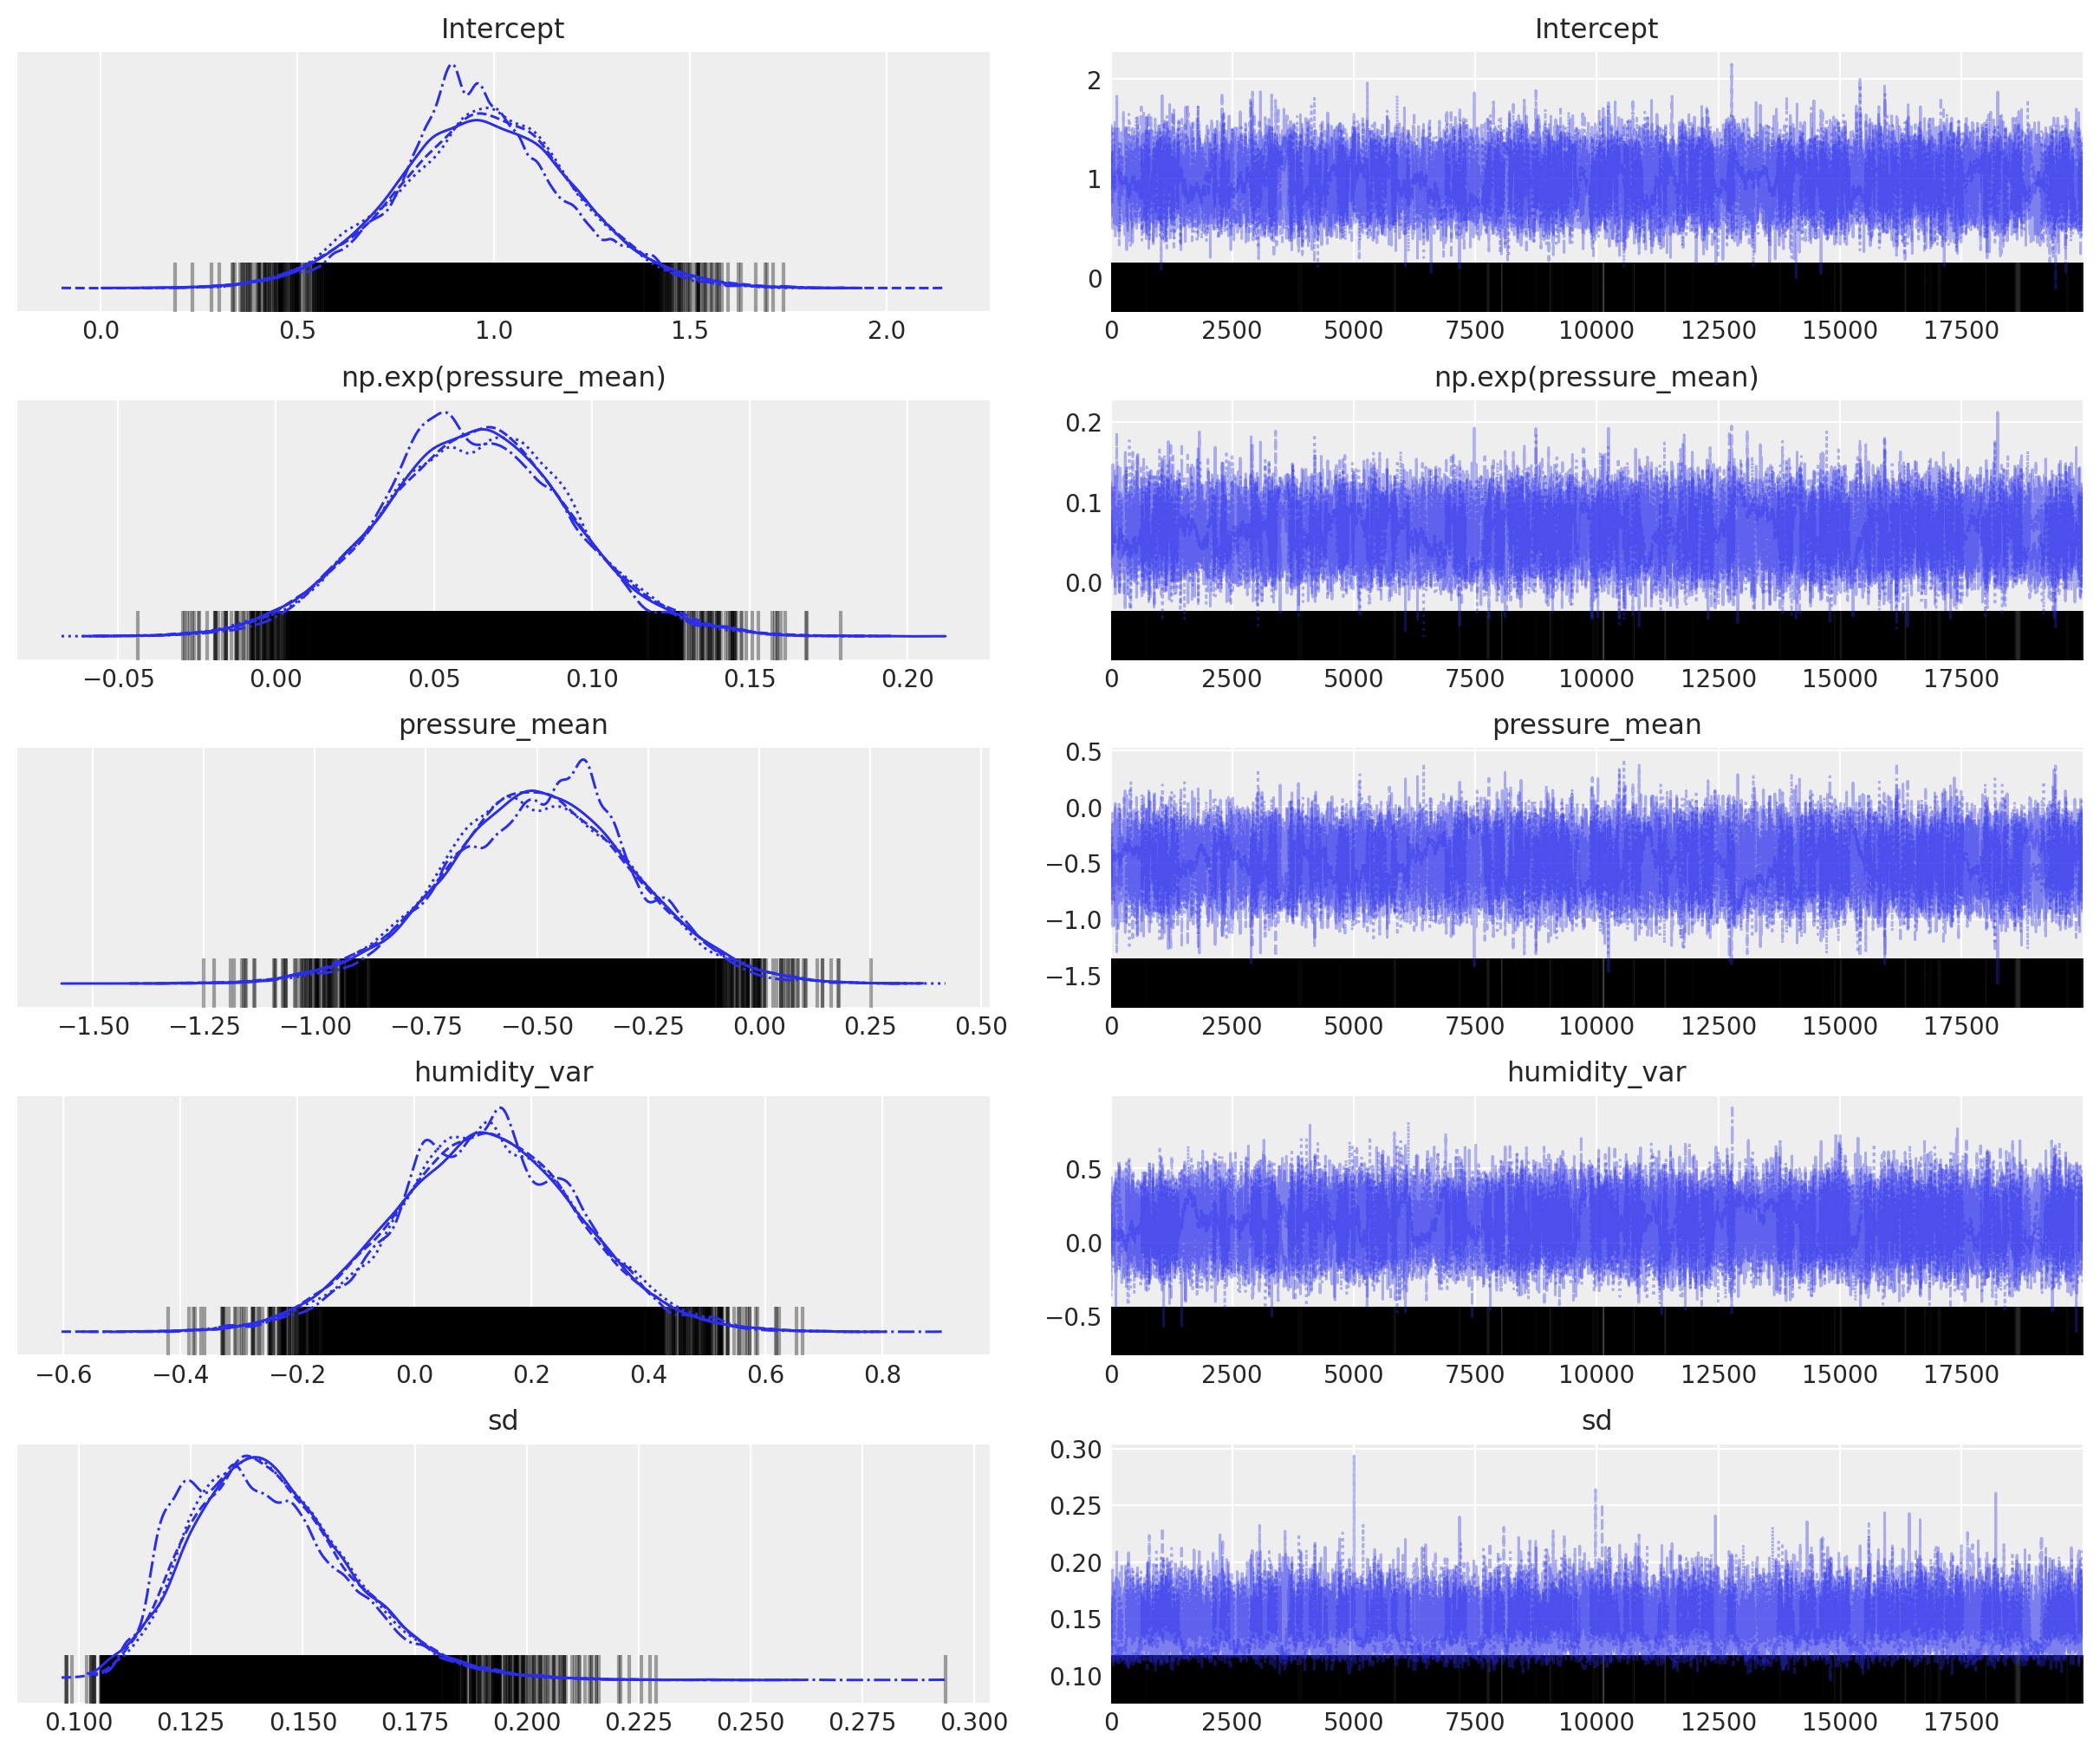

In [66]:
spotato_weather = pd.merge(left=year_weather_df, right=sweet_potato, left_on='year', right_on='year')
spotato_weather = spotato_weather.drop(['area-code', 'year'], axis=1)
spotato_weather = spotato_weather[['pressure_mean', 'humidity_var', 'temp_max', 'val']]


spotato_weather['pressure_mean'] = np.exp(spotato_weather['pressure_mean'])
spotato_weather['temp_max'] = np.exp(spotato_weather['temp_max'])


with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula(potato_formula, spotato_weather)
    idata = pm.sample(20000, init='advi+adapt_diag', progressbar = True, tune = 10000, return_inferencedata=True)
    az.plot_trace(idata)

In [74]:
idata.mean()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Citrus

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 33800
Interrupted at 33,799 [16%]: Average Loss = 132.47
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, np.exp(rain_var), pressure_mean, np.exp(rain_mean), Intercept]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 97 seconds.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 220 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


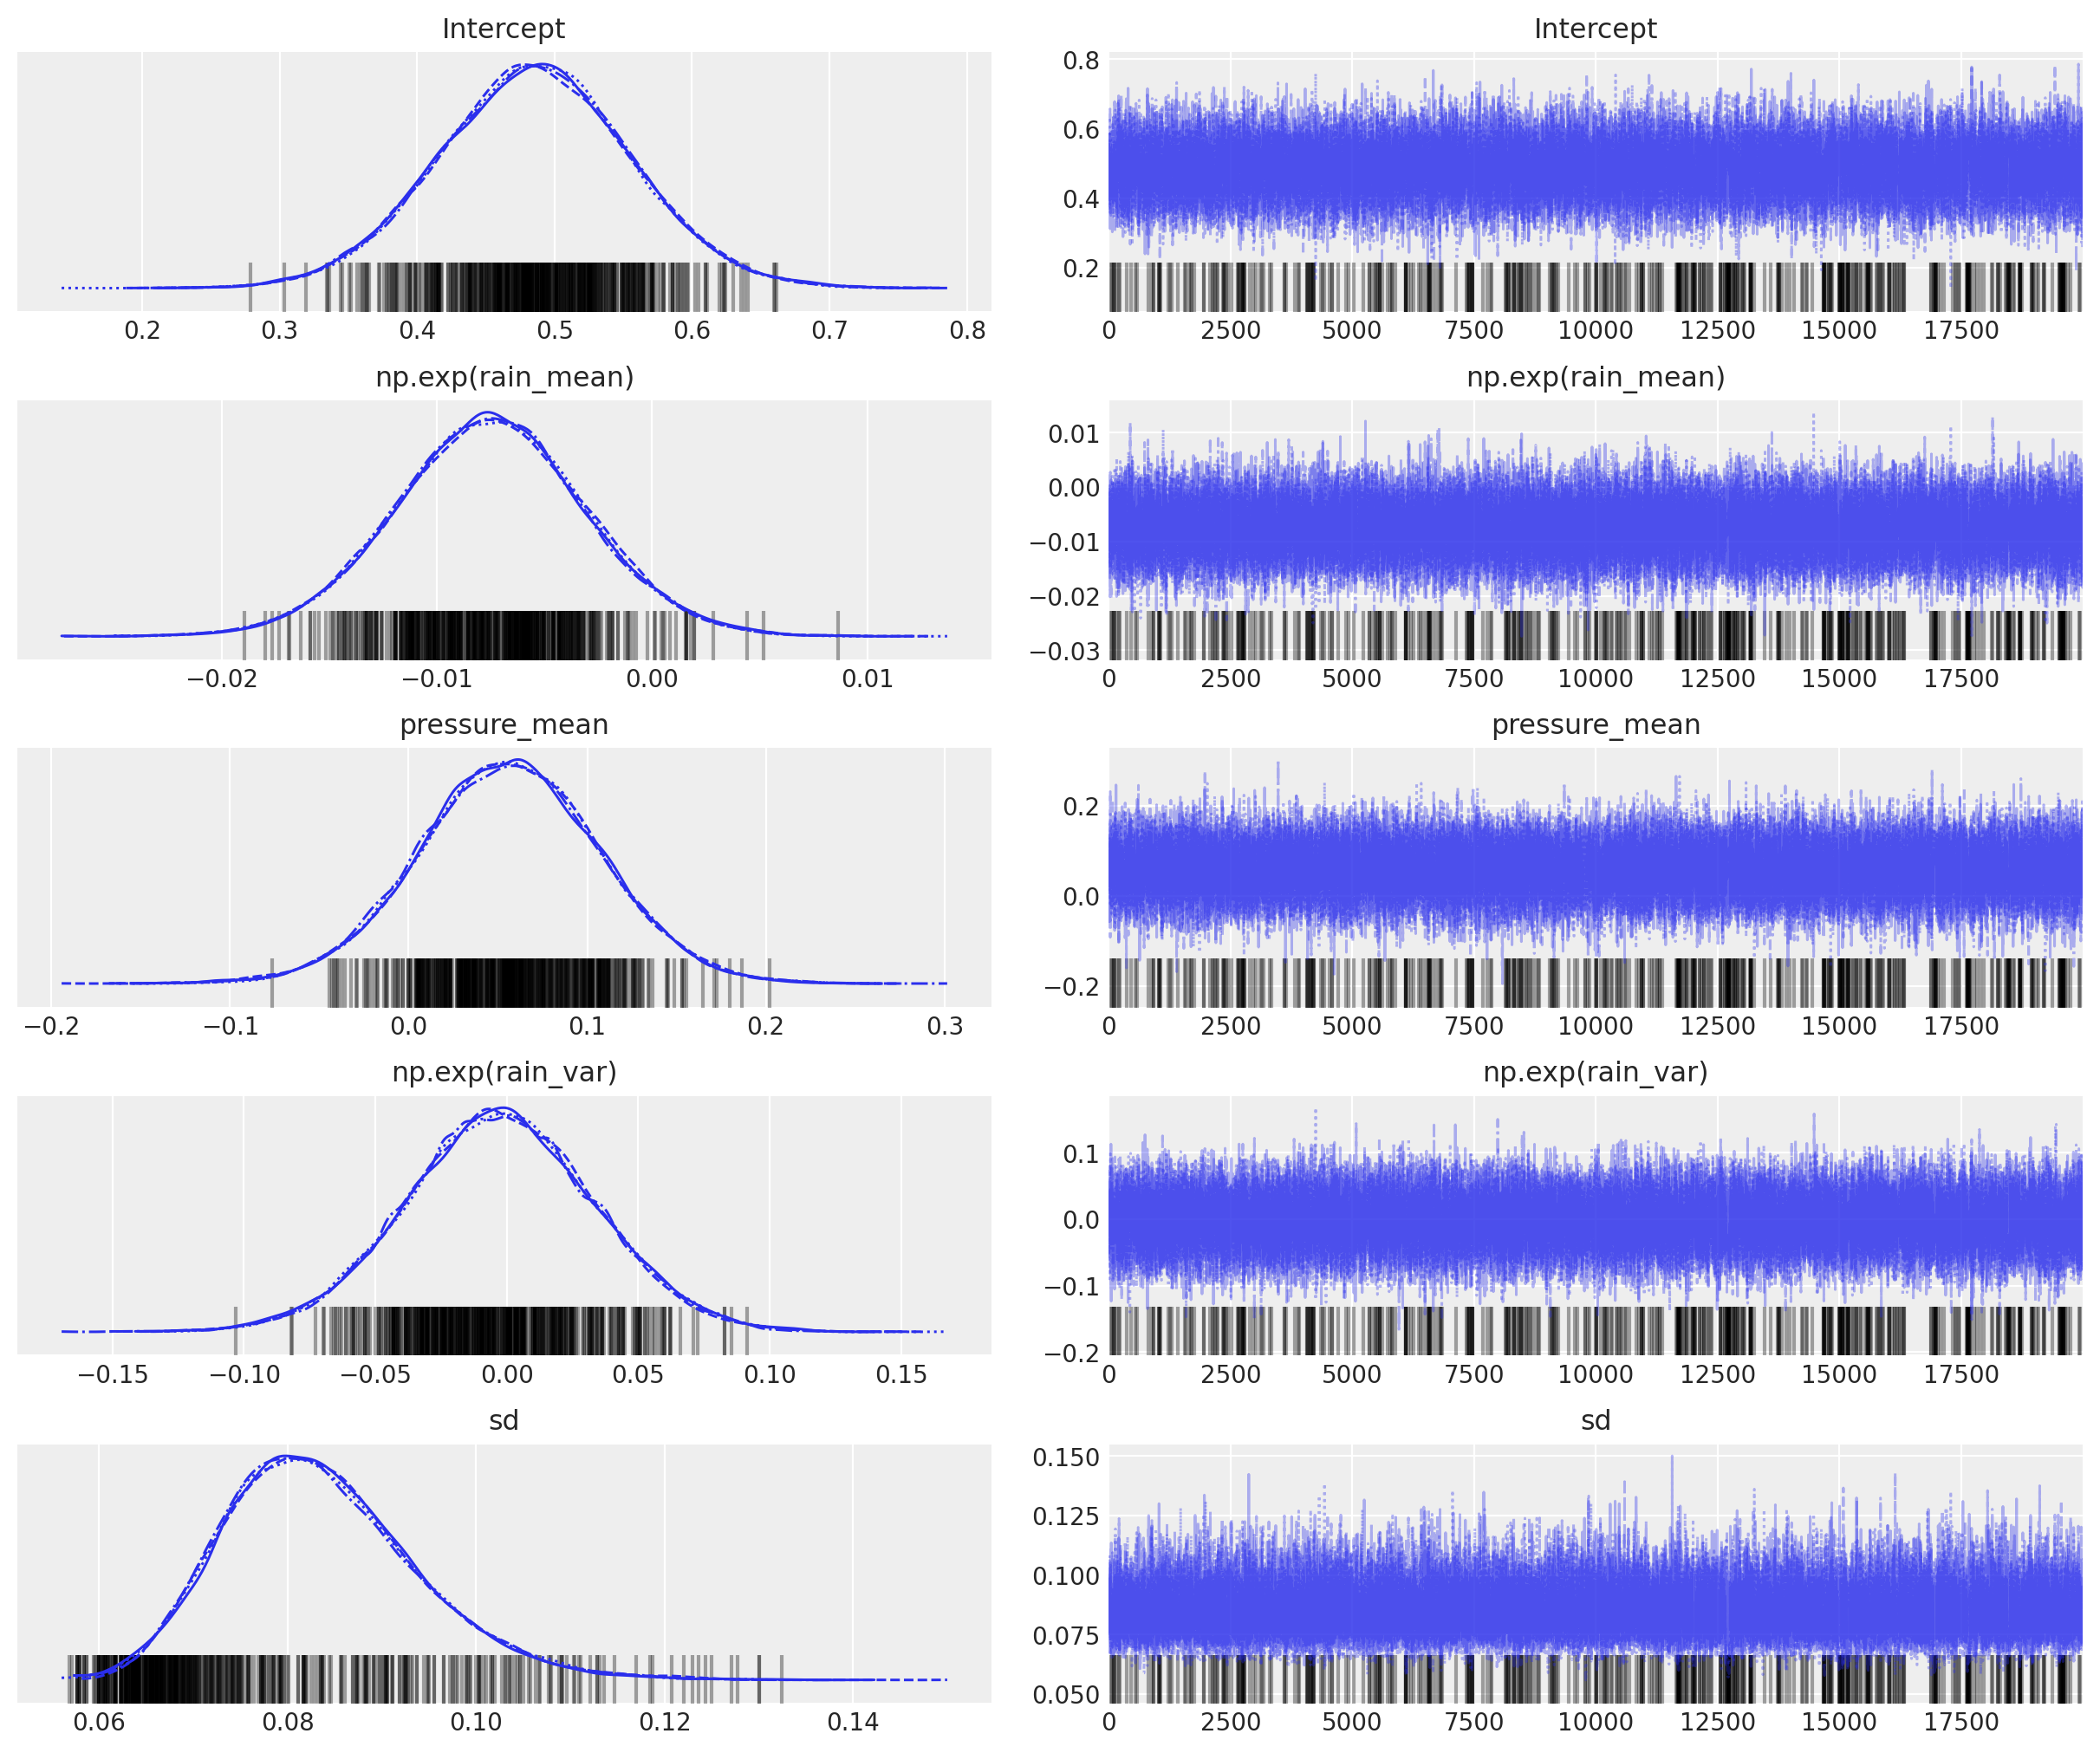

In [80]:
## rain_mean (exp), pressure_mean(None) and rain_var(None)
# Context for the model

citrus_weather = pd.merge(left=year_weather_df, right=citrus, left_on='year', right_on='year')
citrus_weather = citrus_weather.drop(['area-code', 'year'], axis=1)
citrus_weather = citrus_weather[['pressure_mean', 'rain_mean', 'rain_var', 'val']]

citrus_weather['rain_mean'] = np.exp(citrus_weather['rain_mean'])

with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula(citrus_formula, citrus_weather)
    idata = pm.sample(20000, init='advi+adapt_diag', progressbar = True, tune = 10000, return_inferencedata=True)
    az.plot_trace(idata)

In [81]:
idata.mean()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Pigeon Peas

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 15800
Interrupted at 15,799 [7%]: Average Loss = 69.351
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, temp_max, temp_min, Intercept]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 83 seconds.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


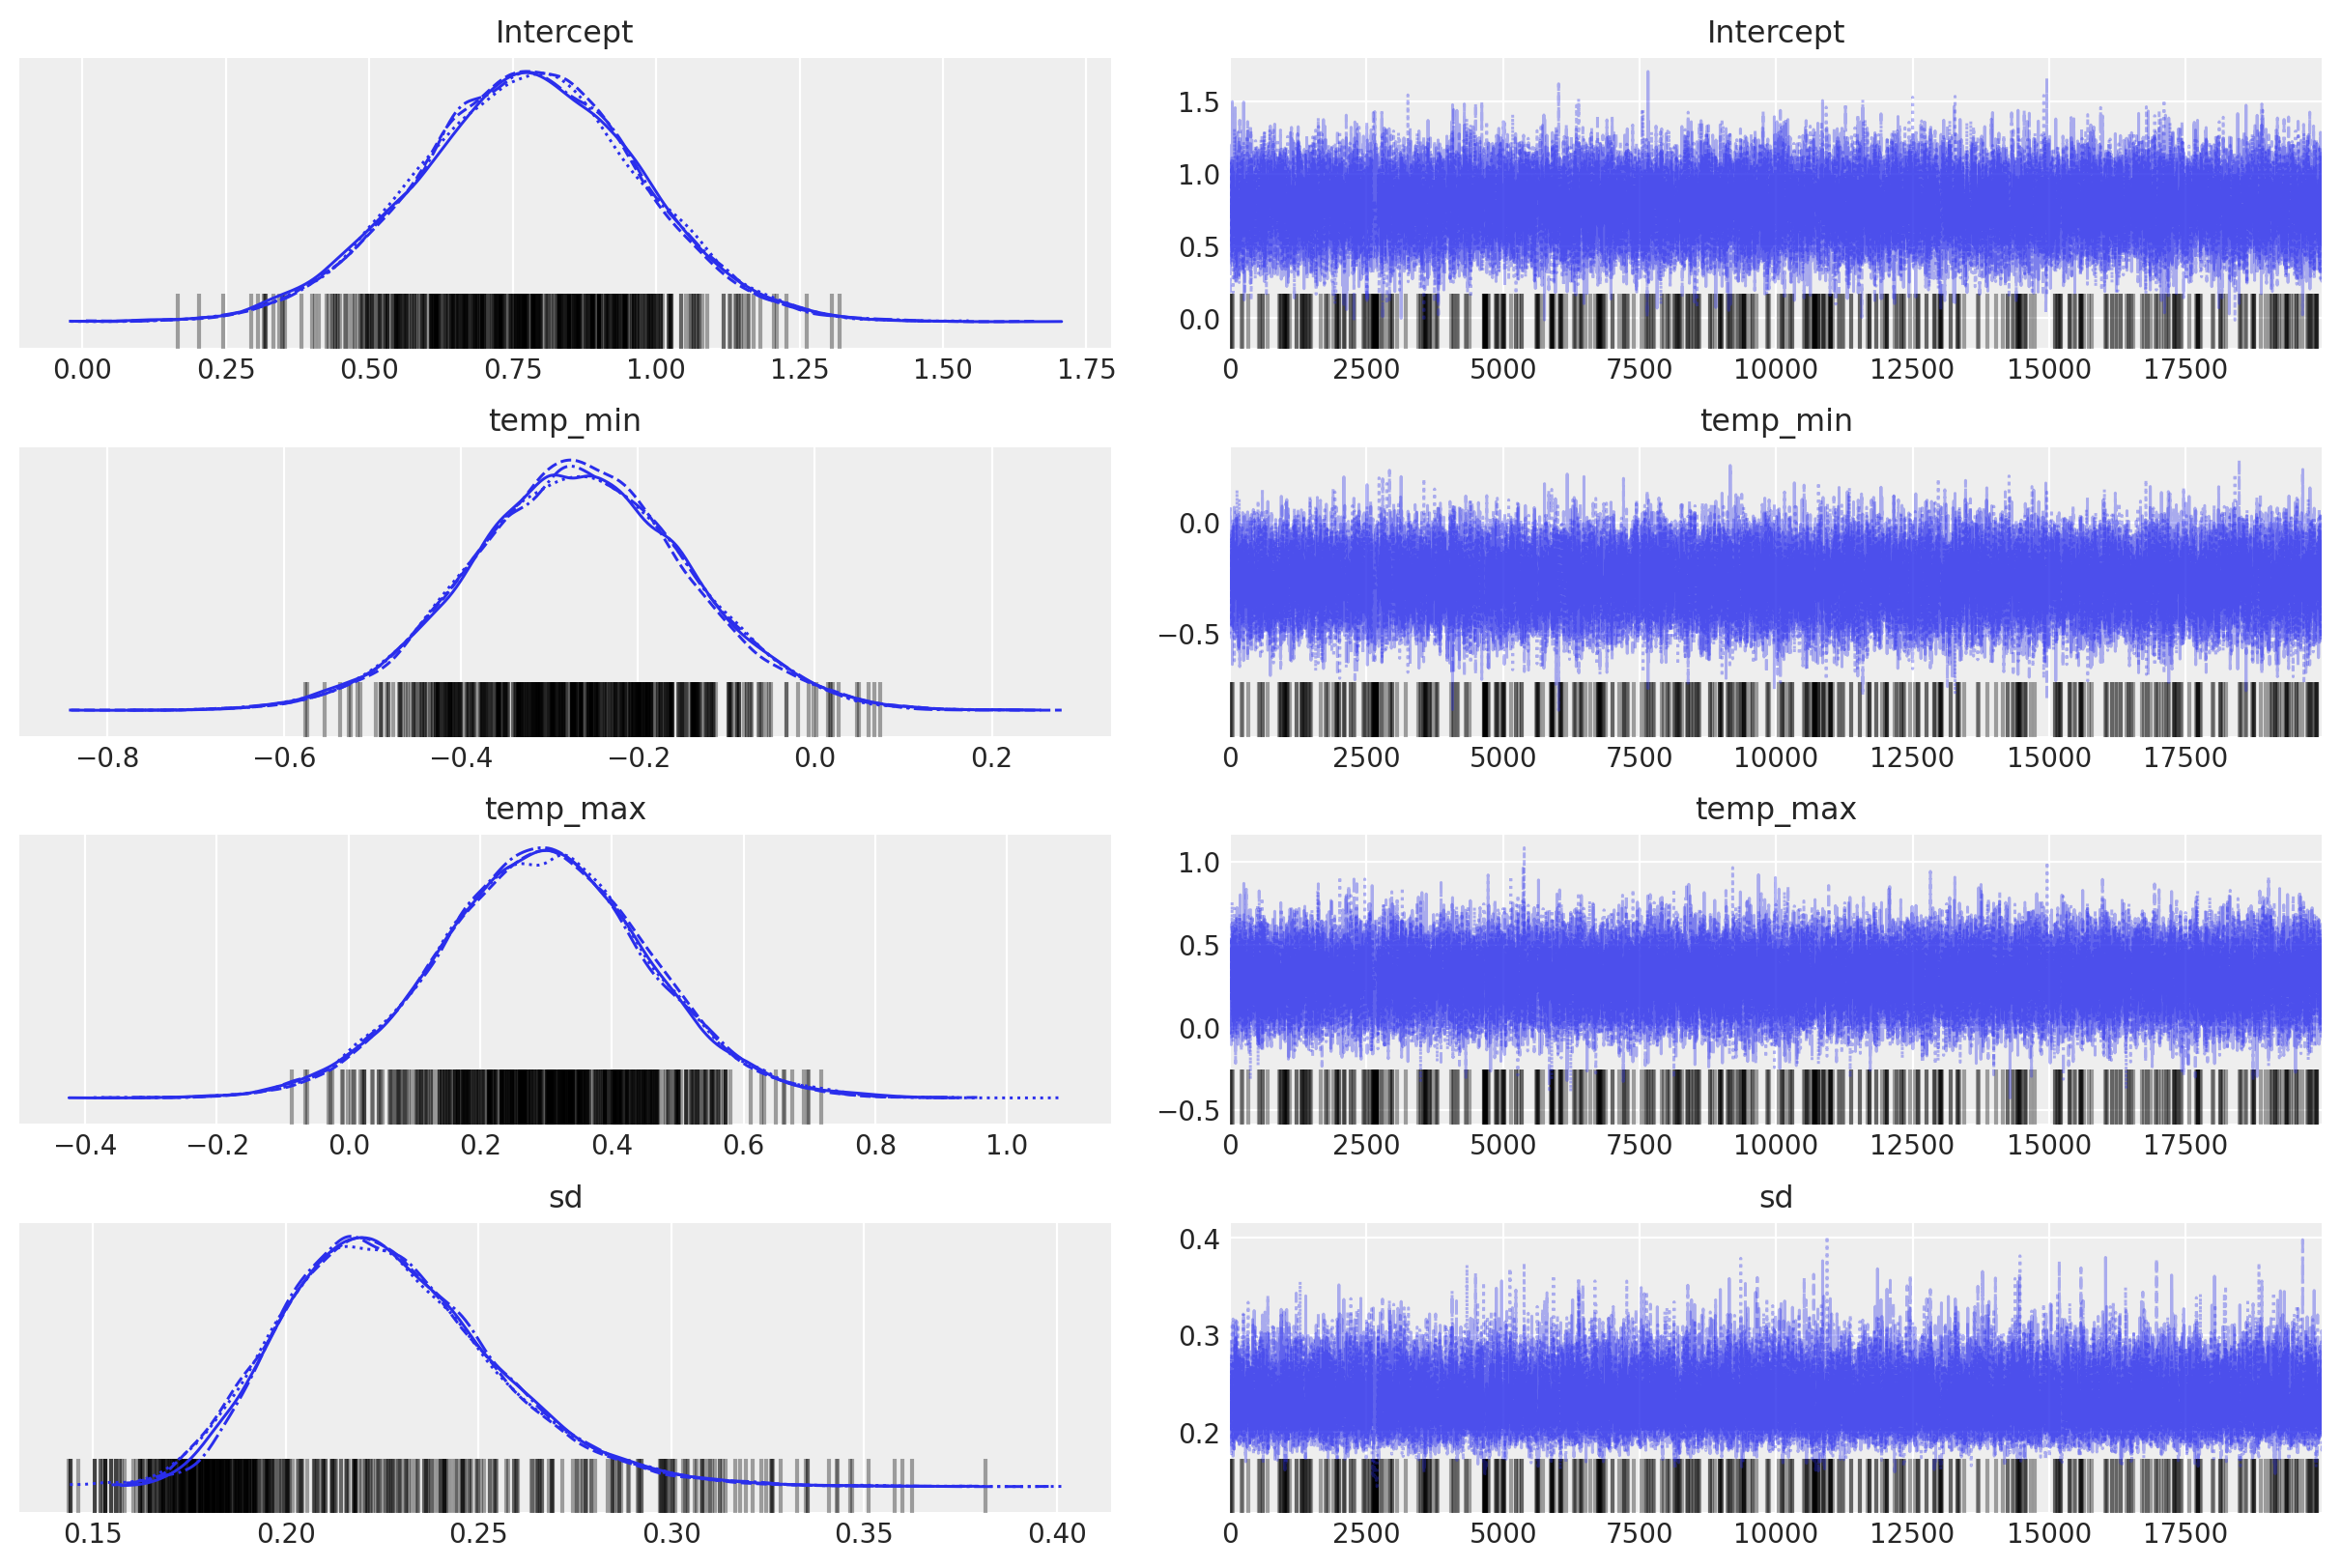

In [75]:
## temp_min (exp), temp_min(None), and temp_max (None)
# Context for the model

peas_weather = pd.merge(left=year_weather_df, right=pigeon_peas, left_on='year', right_on='year')
peas_weather = peas_weather.drop(['area-code', 'year'], axis=1)
peas_weather = peas_weather[['temp_min', 'temp_max', 'val']]


peas_weather['temp_min'] = np.exp(peas_weather['temp_min'])

with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula("val ~ temp_min + temp_max", peas_weather)
    idata = pm.sample(20000, init='advi+adapt_diag', progressbar = True, tune = 10000, return_inferencedata=True)
    az.plot_trace(idata)

In [76]:
idata.mean()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Standard Regression
## Sweet Potato

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
clf = LinearRegression()

# pressure_mean (exp), temp_max (exp)

X_potato, y_potato = spotato_weather[['pressure_mean', 'humidity_var']], spotato_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_potato, y_potato, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')


Coefficients: [-0.06795029  0.19730151], Intercept: 0.6062504707779577


## Citrus

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
clf = LinearRegression()

#  rain_mean (exp), pressure_mean(None) and rain_var(None)

X_citrus, y_citrus = citrus_weather[['rain_mean', 'pressure_mean', 'rain_var']], citrus_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_citrus, y_citrus, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-0.01557557  0.03263619 -0.00763393], Intercept: 0.48086858250801057


## Pigeon Peas

In [62]:
clf = LinearRegression()

## temp_min (exp), temp_min(None), and temp_max (None)

X_peas, y_peas = peas_weather[['temp_min', 'temp_max']], citrus_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_peas, y_peas, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-0.01103747  0.00742018], Intercept: 0.48056022322288927


# Bayesian Ridge Regression
## Sweet Potato

In [78]:
from sklearn.linear_model import BayesianRidge

clf = BayesianRidge()

# pressure_mean (exp), temp_max (exp)

X_potato, y_potato = spotato_weather[['pressure_mean', 'humidity_var']], spotato_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_potato, y_potato, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-0.06485389  0.09310743], Intercept: 0.6817283336508237


## Citrus

In [64]:
clf = BayesianRidge()

#  rain_mean (exp), pressure_mean(None) and rain_var(None)

X_citrus, y_citrus = citrus_weather[['rain_mean', 'pressure_mean', 'rain_var']], citrus_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_citrus, y_citrus, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-0.00085566  0.00086965 -0.00013873], Intercept: 0.467727533309953


## Pigeon Peas

In [65]:
clf = BayesianRidge()

## temp_min (exp), temp_min(None), and temp_max (None)

X_peas, y_peas = peas_weather[['temp_min', 'temp_max']], citrus_weather['val']
X_train, X_test, y_train, y_test = train_test_split(X_peas, y_peas, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print(f'Coefficients: {clf.coef_}, Intercept: {clf.intercept_}')

Coefficients: [-5.04409361e-04  7.41140898e-05], Intercept: 0.46734554131456396


# Model Evaluation

The following code are exact functions (minus the object-oriented specifics) as pushed to our github, and the following serves as a method for investigating the performance of the method on predicting crop-yield optimality for the previous years

## Step I -  Firebase Authentication 

In [1]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import credentials, firestore, initialize_app, db

cred = credentials.Certificate('crop-jedi-storage-firebase-adminsdk-scef3-882ee18ae0.json')
app = firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://crop-jedi-storage-default-rtdb.firebaseio.com/'
})

## Step II - Pull Past Weather Data from Firebase

In [2]:
temp_ref = db.reference('weather_data')
#OrganiseData.getWeather()
weather_data = temp_ref.get(temp_ref)

In [3]:
weather_data[0].keys()

dict_keys(['humidity_mean', 'humidity_var', 'pressure_mean', 'pressure_var', 'rain_mean', 'rain_var', 'temp', 'temp_max', 'temp_min'])

## Step III - Filter Weather Data
Weather data for the past 6 months is used to forecast, in the following function, the weather data is filtered using its keys (which represent tuples in the form (m, YYYY))

In [162]:
from datetime import date

#OrganiseData.filterWeather()
weather_filtered = dict()
weather_keys = ['humidity_mean', 'humidity_var', 'pressure_mean', 'pressure_var', 'rain_mean', 'rain_var', 'temp', 'temp_max', 'temp_min']
for weather_key in weather_keys:
    month_current = int(date.today().strftime('%m'))
    year_current = int(date.today().strftime('%Y'))
    temp_key_data = weather_data[0][weather_key]
    # To Store retrieved data
    temp_list = []
    for temp_data in temp_key_data.items():
        ## Gets most recent year        
        if int(temp_data[0][-6:-1])>= year_current-3:
            
            temp_list.append(temp_data[1])
    weather_filtered[weather_key] = temp_list    
    
weather_filtered.keys()

humidity_mean
humidity_var
pressure_mean
pressure_var
rain_mean
rain_var
temp
temp_max
temp_min


dict_keys(['humidity_mean', 'humidity_var', 'pressure_mean', 'pressure_var', 'rain_mean', 'rain_var', 'temp', 'temp_max', 'temp_min'])

In [26]:
def filterWeather(weather_data, year):
    weather_filtered = dict()
    weather_keys = ['humidity_mean', 'humidity_var', 'pressure_mean', 'pressure_var', 'rain_mean', 'rain_var', 'temp', 'temp_max', 'temp_min']
    for weather_key in weather_keys:
        month_current = 7
        year_current = year
        temp_key_data = weather_data[0][weather_key]
        # To Store retrieved data
        temp_list = []
        for temp_data in temp_key_data.items():
            ## Gets most recent year        
            if int(temp_data[0][-6:-1])>= year_current-3:

                temp_list.append(temp_data[1])
        weather_filtered[weather_key] = temp_list  
        
    return weather_filtered

Weather data is scaled using pre-trained scalers found during building the model and all data is reshaped to be the same length (to account for null values in rain_1h and rain_3h)

In [6]:
import pickle
import numpy as np

scalers = dict()
scalers['humidity_mean'] = pickle.load(open('scalers/humidity_mean_scaler.pkl', 'rb'))
scalers['humidity_var'] = pickle.load(open('scalers/humidity_var_scaler.pkl', 'rb'))
scalers['pressure_mean'] = pickle.load(open('scalers/pressure_mean_scaler.pkl', 'rb'))
scalers['pressure_var'] = pickle.load(open('scalers/pressure_var_scaler.pkl', 'rb'))
scalers['rain_mean'] = pickle.load(open('scalers/rain_mean_scaler.pkl', 'rb'))
scalers['rain_var'] = pickle.load(open('scalers/rain_var_scaler.pkl', 'rb'))
scalers['temp'] = pickle.load(open('scalers/temp_scaler.pkl', 'rb'))
scalers['temp_max'] = pickle.load(open('scalers/temp_max_scaler.pkl', 'rb'))
scalers['temp_min'] = pickle.load(open('scalers/temp_min_scaler.pkl', 'rb'))
     
# for weather in weather_filtered.items():
#     # weather is a tuple, for example: ('humidity_mean', [array containing values for humidity_mean])
#     label = weather[0]
#     data = weather[1]
#     weather_filtered[label] = scalers[label].transform(np.array(data).reshape(-1,1))

def scale_weather(weather_filtered):
    for weather in weather_filtered.items():
        # weather is a tuple, for example: ('humidity_mean', [array containing values for humidity_mean])
        label = weather[0]
        data = weather[1]
        weather_filtered[label] = scalers[label].transform(np.array(data).reshape(-1,1)) 

In [164]:
import pandas as pd

# was scaled above
scaled_data = weather_filtered
index = [i for i in range(len(scaled_data[weather_keys[0]]))]
shortest_val = np.Inf
for i in scaled_data.items():
    shortest_val = min(i[1].shape[0], shortest_val)
scaled_df = pd.DataFrame(
    {
        weather_keys[0]: np.transpose(scaled_data[weather_keys[0]])[0][-shortest_val:],
        weather_keys[1]: np.transpose(scaled_data[weather_keys[1]])[0][-shortest_val:],
        weather_keys[2]: np.transpose(scaled_data[weather_keys[2]])[0][-shortest_val:],
        weather_keys[3]: np.transpose(scaled_data[weather_keys[3]])[0][-shortest_val:],
        weather_keys[4]: np.transpose(scaled_data[weather_keys[4]])[0][-shortest_val:],
        weather_keys[5]: np.transpose(scaled_data[weather_keys[5]])[0][-shortest_val:],
        weather_keys[6]: np.transpose(scaled_data[weather_keys[6]])[0][-shortest_val:],
        weather_keys[7]: np.transpose(scaled_data[weather_keys[7]])[0][-shortest_val:],
        weather_keys[8]: np.transpose(scaled_data[weather_keys[8]])[0][-shortest_val:],
        # following columns not being used
        'peas': [-1]*shortest_val, 
        'citrus': [-1]*shortest_val, 
        'potato': [-1]*shortest_val, 
    },
    index = index
)
scaled_df.describe()

humidity_mean  humidity_var  pressure_mean  pressure_var  rain_mean  \
count      24.000000     24.000000      24.000000     24.000000  24.000000   
mean       80.324474    162.986225    1012.493987      4.112080   0.631933   
std         1.554948     13.229986       0.610348      0.371571   0.051652   
min        78.248270    134.543558    1010.751353      2.802790   0.556331   
25%        78.934260    158.665951    1012.222530      3.904484   0.577246   
50%        80.341682    166.986501    1012.559396      4.221986   0.645747   
75%        80.988374    172.226168    1013.024529      4.325014   0.669388   
max        83.048111    177.835881    1013.107165      4.675099   0.707648   

        rain_var           temp    temp_max    temp_min  peas  citrus  potato  
count  24.000000      24.000000   24.000000   24.000000  24.0    24.0    24.0  
mean    0.301610  833015.129785  301.225763  298.694406  -1.0    -1.0    -1.0  
std     0.030095     623.755653    0.292474    0.181320   0.0     0.0     0.0  
min     0.232195  831938.354502  300.761761  298.376536  -1.0    -1.0    -1.0  
25%     0.287653  832630.169307  301.026130  298.585255  -1.0    -1.0    -1.0  
50%     0.296498  832915.217871  301.191626  298.686152  -1.0    -1.0    -1.0  
75%     0.309061  833576.869010  301.492572  298.845728  -1.0    -1.0    -1.0  
max     0.369201  833952.270895  301.626787  298.982706  -1.0    -1.0    -1.0

In [18]:
def transform_data(weather_filtered):
    weather_keys = ['humidity_mean', 'humidity_var', 'pressure_mean', 'pressure_var', 'rain_mean', 'rain_var', 'temp', 'temp_max', 'temp_min']
    scaled_data = weather_filtered
    index = [i for i in range(len(scaled_data[weather_keys[0]]))]
    shortest_val = np.Inf
    for i in scaled_data.items():
        shortest_val = min(i[1].shape[0], shortest_val)
    scaled_df = pd.DataFrame(
        {
            weather_keys[0]: np.transpose(scaled_data[weather_keys[0]])[0][-shortest_val:],
            weather_keys[1]: np.transpose(scaled_data[weather_keys[1]])[0][-shortest_val:],
            weather_keys[2]: np.transpose(scaled_data[weather_keys[2]])[0][-shortest_val:],
            weather_keys[3]: np.transpose(scaled_data[weather_keys[3]])[0][-shortest_val:],
            weather_keys[4]: np.transpose(scaled_data[weather_keys[4]])[0][-shortest_val:],
            weather_keys[5]: np.transpose(scaled_data[weather_keys[5]])[0][-shortest_val:],
            weather_keys[6]: np.transpose(scaled_data[weather_keys[6]])[0][-shortest_val:],
            weather_keys[7]: np.transpose(scaled_data[weather_keys[7]])[0][-shortest_val:],
            weather_keys[8]: np.transpose(scaled_data[weather_keys[8]])[0][-shortest_val:],
            # following columns not being used
            'peas': [-1]*shortest_val, 
            'citrus': [-1]*shortest_val, 
            'potato': [-1]*shortest_val, 
        },
        index = index
    )
    
    return scaled_df

## Step IV - Prediction Functions
*(commented inline)*

In [9]:
def _choose_crop(weather_data, crop):
    '''
        Utility function to return data per crop
    '''
    data = dict()
    potato_keys = ['pressure_mean', 'temp_max']
    citrus_keys = ['rain_mean', 'pressure_mean', 'rain_var']
    peas_keys = ['temp_min', 'temp_max']

    if crop == 'POTATO':           
        data['pressure_mean'] = np.exp(np.mean(weather_filtered['pressure_mean']))
        data['temp_max'] = np.exp(np.mean(weather_filtered['temp_max']))

    if crop == 'CITRUS':
        data['rain_mean'] = rain_mean = np.exp(np.mean(weather_filtered['rain_mean']))
        data['pressure_mean'] = np.mean(weather_filtered['pressure_mean'])
        data['rain_var'] = np.mean(weather_filtered['rain_var'])

    if crop == 'PIGEON_PEA':            
        data['temp_min'] = np.exp(np.mean(weather_filtered['temp_min']))
        data['temp_min_raw'] = np.mean(weather_filtered['temp_min'])
        data['temp_max'] = np.mean(weather_filtered['temp_max'])

    return data, data.keys()

def predict_crop_feasibility(weather_data, model_params):
    '''
        Base function for calculating feasibility for ALL crops and returning scores
    '''
    
    potato_data = _choose_crop(weather_data, crop='POTATO')
    citrus_data = _choose_crop(weather_data, crop='CITRUS')
    peas_data = _choose_crop(weather_data, crop='PEAS')

    potato = _predict_crop_feasibility(potato_data, model_params['POTATO'])
    citrus = _predict_crop_feasibility(citrus_data, model_params['CITRUS'])
    peas = _predict_crop_feasibility(peas_data, model_params['PEAS'])

    divisor = max([potato, citrus, peas])
    potato /= divisor
    citrus /= divisor
    peas /= divisor

    return potato, citrus, peas

def _predict_crop_feasibility(crop, model_params):
    '''
        Base function for predicting feasibility of single crop given crop and model parameters
    '''
    crop_data, crop_keys = crop[0], crop[1]
    res = 0.0

    for crop_key in crop_keys:
        res += crop_data[crop_key] * model_params[crop_key]

    res+= model_params['intercept']
    return res

In [10]:
'''
    Linear regression parameters for all models 
    file not executable, dictionaries meant to be imported and used for
    future calculations
'''
pymc3_params = dict({
    'POTATO': {
        'pressure_mean': -0.01, 
        'temp_max': -0.005, 
        'intercept': 0.68
    },
    'CITRUS': {
        'rain_mean': -0.04, 
        'pressure_mean': 0.08, 
        'rain_var': -0.01, 
        'intercept': 0.51
    },
    'PEAS': {
        'temp_min': -0.28,
        'temp_max': 0.30, 
        'intercept': 0.76
    }

})

lr_params = dict({
    'POTATO': {
        'pressure_mean': -0.0055, 
        'temp_max': 0.0083, 
        'intercept': 0.6375
    },
    'CITRUS': {
        'rain_mean': -0.0155, 
        'pressure_mean': 0.0326, 
        'rain_var': -0.0076, 
        'intercept': 0.4809 
    },
    'PEAS': {
        'temp_min': -0.0110,
        'temp_max': 0.0074, 
        'intercept': 0.4806
    }

})

ridge_params = dict({
    'POTATO': {
        'pressure_mean': -0.0001, 
        'temp_max': 0.0002,  
        'intercept': 0.6423
    },
    'CITRUS': {
        'rain_mean': -0.0009, 
        'pressure_mean': 0.0009, 
        'rain_var': -0.0001, 
        'intercept': 0.4677 
    },
    'PEAS': {
        'temp_min': -0.0005,
        'temp_max': 0.0074, 
        'intercept': 0.4673
    }

})

## Step V - Exponential Forecasting and RMSE Calculation

In [195]:
for dtype, col in zip(scaled_df.dtypes, scaled_df.columns):
    if dtype == 'float64':
        scaled_df[col] = scaled_df[col].astype('float32')
    if dtype == 'int64':
            scaled_df[col] = scaled_df[col].astype('int8')
        

humidity_mean  humidity_var  pressure_mean  pressure_var  rain_mean  \
0       80.485916    175.777206    1013.084473      3.686175   0.556331   
1       78.248268    171.706848    1012.728821      4.405695   0.652326   
2       80.341682    177.835876    1013.107178      3.826500   0.566537   
3       78.348938    168.672943    1012.559387      4.316869   0.658409   
4       80.341682    177.835876    1013.107178      3.826500   0.566537   
5       78.348938    168.672943    1012.559387      4.316869   0.658409   
6       80.341682    177.835876    1013.107178      3.826500   0.566537   
7       78.348938    168.672943    1012.559387      4.316869   0.658409   
8       80.341682    177.835876    1013.107178      3.826500   0.566537   
9       78.348938    168.672943    1012.559387      4.316869   0.658409   
10      80.852036    173.784149    1013.026367      3.930479   0.578339   
11      78.714500    160.919159    1012.395752      4.189706   0.667789   
12      81.397400    168.384506    1013.023926      4.007601   0.573967   
13      79.007515    155.114334    1012.256104      4.254265   0.674185   
14      82.110245    162.941467    1012.981628      4.143734   0.590196   
15      79.491486    149.010254    1012.121887      4.359895   0.683604   
16      82.577484    161.443970    1012.844666      4.349450   0.606904   
17      79.939461    143.041840    1012.043762      4.675099   0.694864   
18      82.924713    159.849823    1012.598450      4.295538   0.625693   
19      80.129539    140.198868    1011.721863      4.388668   0.704248   
20      83.048111    165.588501    1012.338379      4.389800   0.639168   
21      80.463669    138.136765    1011.344177      4.062122   0.707648   
22      82.843269    165.192871    1011.927795      4.175422   0.606493   
23      80.791275    134.543564    1010.751343      2.802790   0.704850   

    rain_var         temp    temp_max    temp_min  peas  ...  peas_pymc3  \
0   0.281376  831938.3750  300.761749  298.376526    -1  ...    0.009333   
1   0.291097  832952.5625  301.251862  298.570282    -1  ...    0.009333   
2   0.287653  832159.5625  300.833954  298.452209    -1  ...    0.009333   
3   0.299584  833308.7500  301.370850  298.706879    -1  ...    0.009333   
4   0.287653  832159.5625  300.833954  298.452209    -1  ...    0.009333   
5   0.299584  833308.7500  301.370850  298.706879    -1  ...    0.009333   
6   0.287653  832159.5625  300.833954  298.452209    -1  ...    0.009333   
7   0.299584  833308.7500  301.370850  298.706879    -1  ...    0.009333   
8   0.287653  832159.5625  300.833954  298.452209    -1  ...    0.009333   
9   0.299584  833308.7500  301.370850  298.706879    -1  ...    0.009333   
10  0.296638  832558.6250  300.974609  298.590240    -1  ...    0.009333   
11  0.308131  833598.6875  301.476196  298.820129    -1  ...    0.009333   
12  0.269937  832743.6875  301.043304  298.655090    -1  ...    0.009333   
13  0.323837  833874.5625  301.577667  298.933777    -1  ...    0.009333   
14  0.281841  832847.6250  301.090576  298.684540    -1  ...    0.009333   
15  0.341685  833952.2500  301.626801  298.982697    -1  ...    0.009333   
16  0.290523  832877.8750  301.118835  298.687744    -1  ...    0.009333   
17  0.364813  833796.1875  301.593628  298.943359    -1  ...    0.009333   
18  0.296359  832854.9375  301.131378  298.678070    -1  ...    0.009333   
19  0.346361  833749.9375  301.601807  298.922485    -1  ...    0.009333   
20  0.283860  832764.4375  301.120239  298.660400    -1  ...    0.009333   
21  0.369201  833756.5625  301.622803  298.947296    -1  ...    0.009333   
22  0.232195  832654.0000  301.065948  298.649292    -1  ...    0.009333   
23  0.311851  833569.5625  301.541718  298.927429    -1  ...    0.009333   

      crop_pymc3  potato_lr  citrus_lr   peas_lr    crop_lr  potato_ridge  \
0   citrus_pymc3        0.0        1.0  0.014365  citrus_lr           0.0   
1   citrus_pymc3        0.0        1.0  0.014365  citrus_lr           0.0

In [30]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error   
from numpy import sqrt
from memo import memlist


def getrmse(scaled_df):
    rmse = dict()
    scaled_df['potato_pymc3'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, pymc3_params)[0], axis=1)
    scaled_df['citrus_pymc3'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, pymc3_params)[1], axis=1)
    scaled_df['peas_pymc3'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, pymc3_params)[2], axis=1)
    scaled_df['crop_pymc3'] = scaled_df[['potato_pymc3', 'citrus_pymc3',
                                         'peas_pymc3']].idxmax(axis=1).replace('_pymc3', '')

    scaled_df['potato_lr'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, lr_params)[0], axis=1)
    scaled_df['citrus_lr'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, lr_params)[1], axis=1)
    scaled_df['peas_lr'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, lr_params)[2], axis=1)
    scaled_df['crop_lr'] = scaled_df[['potato_lr', 'citrus_lr', 'peas_lr']].idxmax(
        axis=1).replace('_lr', '')

    scaled_df['potato_ridge'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, ridge_params)[0], axis=1)
    scaled_df['citrus_ridge'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, ridge_params)[1], axis=1)
    scaled_df['peas_ridge'] = scaled_df.apply(
        lambda x: predict_crop_feasibility(x, ridge_params)[2], axis=1)
    scaled_df['crop_ridge'] = scaled_df[['potato_ridge', 'citrus_ridge',
                                         'peas_ridge']].idxmax(axis=1).replace('_ridge', '')

    exp_potato = SimpleExpSmoothing(np.asarray(scaled_df['potato_pymc3'])).fit(smoothing_level=0.1,optimized=False)
    exp_citrus = SimpleExpSmoothing(np.asarray(scaled_df['citrus_pymc3'])).fit(smoothing_level=0.1,optimized=False)
    exp_peas = SimpleExpSmoothing(np.asarray(scaled_df['peas_pymc3'])).fit(smoothing_level=0.1,optimized=False)
    scaled_df.replace(to_replace=-np.Inf, value=0, inplace=True)
    # FOR RMSE CALCLUATIONS ONLY
    month_current = 7
#     month_current = int(date.today().strftime('%m'))
    potato_month3 = exp_potato.predict(month_current, month_current + 3)
    potato_month3 = [i if i>0 else 0 for i in potato_month3]
    rms1 = sqrt(mean_squared_error(scaled_df['potato_pymc3'][:4], potato_month3))
    rmse['potato_pymc3_3'] = rms1
    
    citrus_month3 = exp_citrus.predict(month_current, month_current + 3)
    citrus_month3 = [i if i>0 else 0 for i in citrus_month3]
    rms2 = sqrt(mean_squared_error(scaled_df['citrus_pymc3'][:4], citrus_month3))
    rmse['citrus_pymc3_3'] = rms2

    peas_month3 = exp_peas.predict(month_current, month_current + 3)
    citrus_month3 = [i if i>0 else 0 for i in citrus_month3]
    rms3 = sqrt(mean_squared_error(scaled_df['peas_pymc3'][:4], peas_month3))
    rmse['peas_pymc3_3'] = rms3

    potato_month6 = exp_potato.predict(month_current, month_current + 6)
    potato_month6 = [i if i>0 else 0 for i in potato_month6]
    rms4 = sqrt(mean_squared_error(scaled_df['potato_pymc3'][:7], potato_month6))
    rmse['potato_pymc3_6'] = rms4

    citrus_month6 = exp_citrus.predict(month_current, month_current + 6)
    citrus_month6 = [i if i>0 else 0 for i in citrus_month6]
    rms5 = sqrt(mean_squared_error(scaled_df['citrus_pymc3'][:7], citrus_month6))
    rmse['citrus_pymc3_6'] = rms5

    peas_month6 = exp_peas.predict(month_current, month_current + 6)
    peas_month6 = [i if i>0 else 0 for i in peas_month6]
    rms6 = sqrt(mean_squared_error(scaled_df['peas_pymc3'][:7], peas_month6))
    rmse['peas_pymc3_6'] = rms6
    return rmse


In [220]:
weather_vals = scaled_df[['humidity_mean', 'humidity_var', 'pressure_mean', 'pressure_var','rain_mean', 'rain_var', 'temp', 'temp_max', 'temp_min']]

In [241]:
import plotly.graph_objects as go
import plotly.express as px

y = scaled_df[['potato_pymc3', 'citrus_pymc3', 'peas_pymc3']]

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['potato_pymc3'], mode='markers', name='Potato')
)
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['peas_pymc3'], mode='markers', name='Peas')
)
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['citrus_pymc3'], mode='markers', name='Citrus')
)

fig.update_layout(
    yaxis_title='Optimality',
    xaxis_title='Month',
    title='Crop Optimality for 2018-19 using GLM'
)

fig.show()

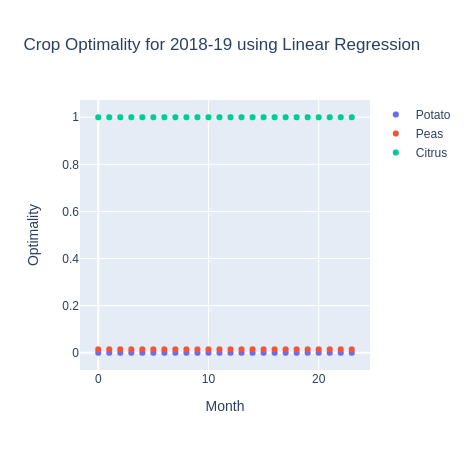

In [242]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['potato_lr'], mode='markers', name='Potato')
)
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['peas_lr'], mode='markers', name='Peas')
)
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['citrus_lr'], mode='markers', name='Citrus')
)

fig.update_layout(
    yaxis_title='Optimality',
    xaxis_title='Month',
    title='Crop Optimality for 2018-19 using Linear Regression'
)

fig.show()

In [243]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['potato_ridge'], mode='markers', name='Potato')
)
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['peas_ridge'], mode='markers', name='Peas')
)
fig.add_trace(
    go.Scatter(x=scaled_df.index, y=scaled_df['citrus_ridge'], mode='markers', name='Citrus')
)

fig.update_layout(
    yaxis_title='Optimality',
    xaxis_title='Month',
    title='Crop Optimality for 2018-19 using Bayesian Ridge Regression'
)

fig.show()

# Testing RMSE 

In [35]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

for year in range(2000, 2018, 1):
    weather_filtered = filterWeather(weather_data, year)
    scale_weather(weather_filtered)
    scaled_df = transform_data(weather_filtered)
    print(f'year: {year}: {getrmse(scaled_df)}')

year: 2000: {'potato_pymc3_3': 0.0, 'citrus_pymc3_3': 0.0, 'peas_pymc3_3': 0.0, 'potato_pymc3_6': 0.0, 'citrus_pymc3_6': 0.0, 'peas_pymc3_6': 0.0}
year: 2001: {'potato_pymc3_3': 0.0, 'citrus_pymc3_3': 0.0, 'peas_pymc3_3': 0.0, 'potato_pymc3_6': 0.0, 'citrus_pymc3_6': 0.0, 'peas_pymc3_6': 0.0}
year: 2002: {'potato_pymc3_3': 0.0, 'citrus_pymc3_3': 0.0, 'peas_pymc3_3': 0.0, 'potato_pymc3_6': 0.0, 'citrus_pymc3_6': 0.0, 'peas_pymc3_6': 0.0}
year: 2003: {'potato_pymc3_3': 0.0, 'citrus_pymc3_3': 0.0, 'peas_pymc3_3': 0.0, 'potato_pymc3_6': 0.0, 'citrus_pymc3_6': 0.0, 'peas_pymc3_6': 0.0}
year: 2004: {'potato_pymc3_3': 0.0, 'citrus_pymc3_3': 0.0, 'peas_pymc3_3': 0.0, 'potato_pymc3_6': 0.0, 'citrus_pymc3_6': 0.0, 'peas_pymc3_6': 0.0}
year: 2005: {'potato_pymc3_3': 0.0, 'citrus_pymc3_3': 0.0, 'peas_pymc3_3': 0.0, 'potato_pymc3_6': 0.0, 'citrus_pymc3_6': 0.0, 'peas_pymc3_6': 0.0}
year: 2006: {'potato_pymc3_3': 0.0, 'citrus_pymc3_3': 0.0, 'peas_pymc3_3': 0.0, 'potato_pymc3_6': 0.0, 'citrus_pymc3_6